## Chapter 8: Linear regression

#  8.4  Feature scaling via standard normalization

Press the button 'Toggle code' below to toggle code on and off for entire this presentation.

In [ ]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is eåxported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib

# demos for this notebook
regress_plotter = superlearn.lin_regression_demos
feature_scaling_tools = superlearn.feature_scaling_tools
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer()
cost_lib = superlearn.cost_functions
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# other functionality 
import copy

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 8.4.1 Feature scaling for single input datasets

<IPython.core.display.Javascript object>


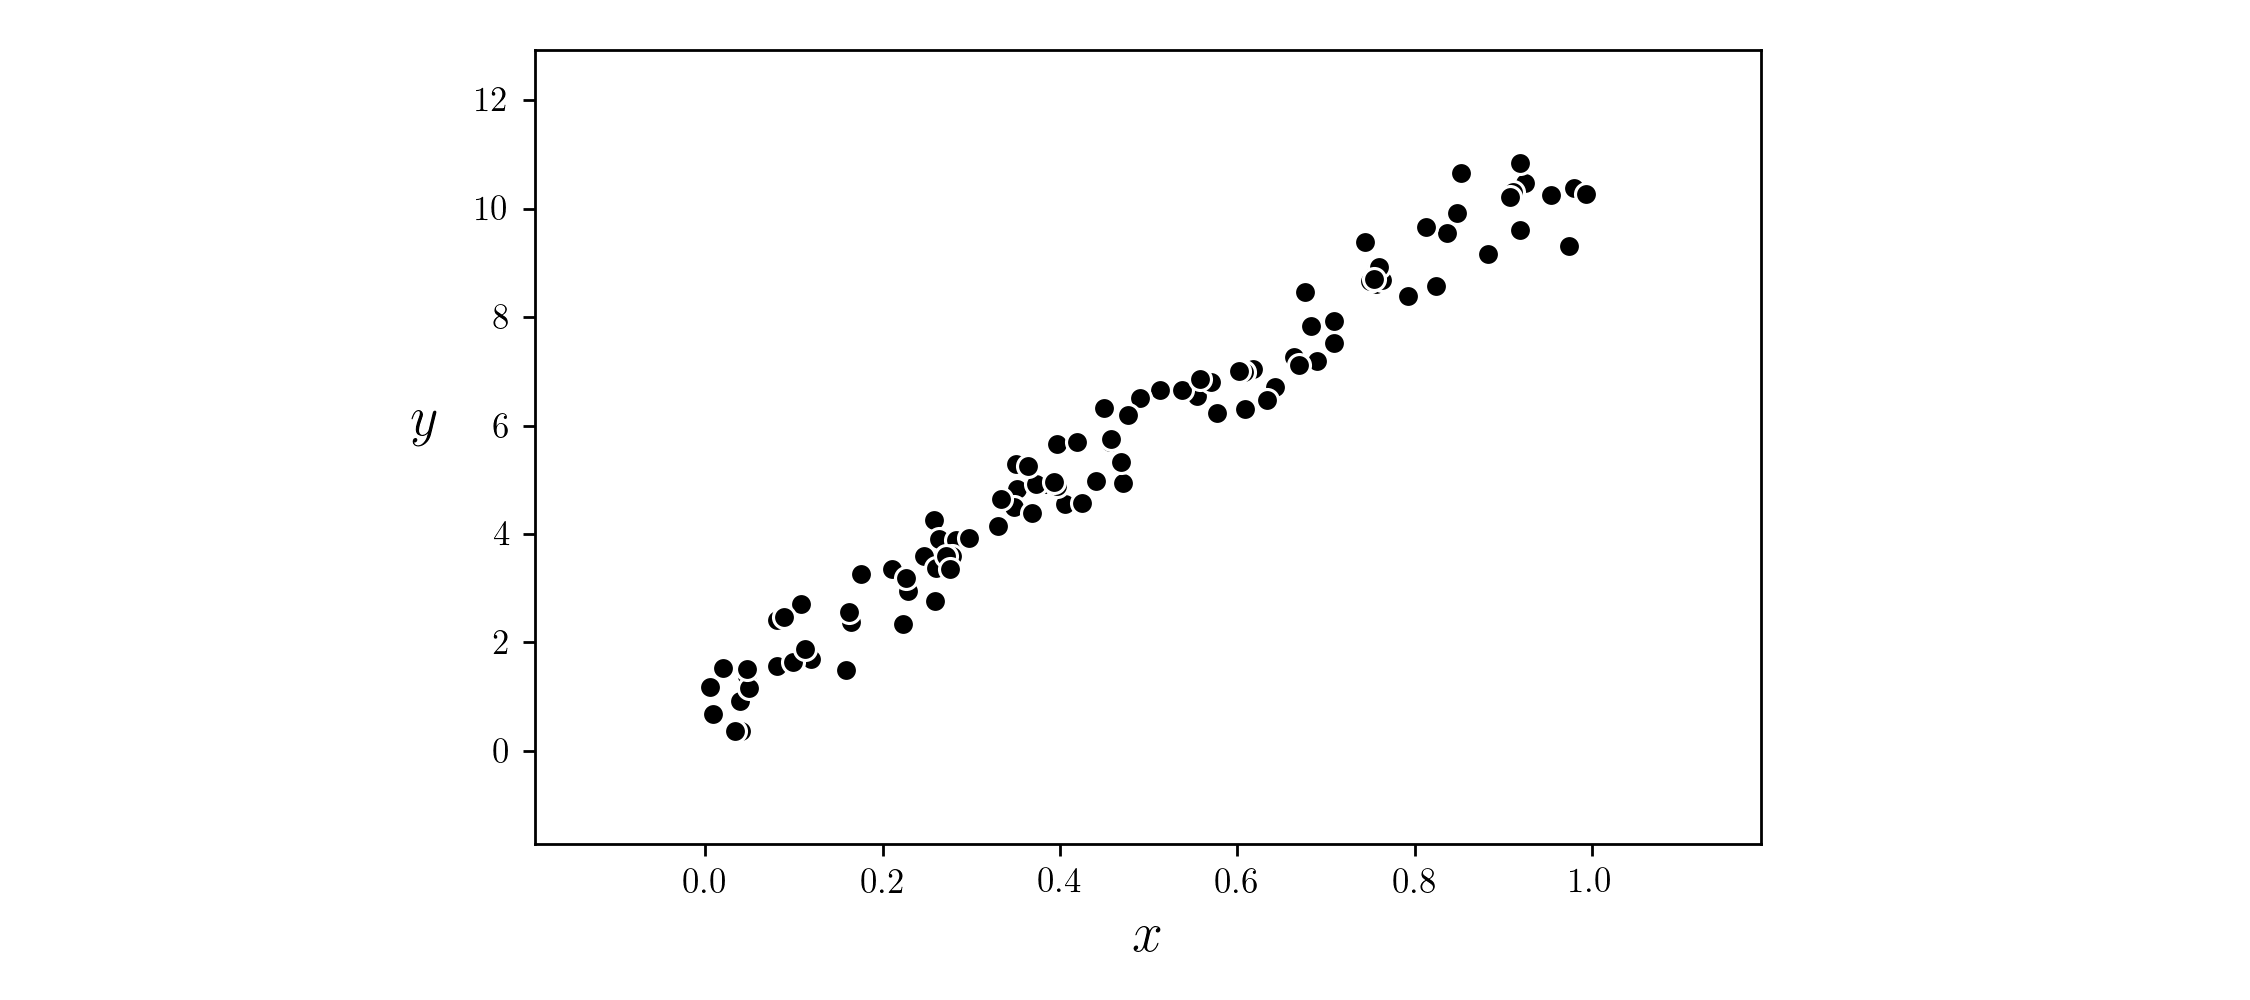

In [2]:
# load data
csvname = datapath + 'unnorm_linregress_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1].T
y = data[:,-1:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

-  only two parameters to learn (the bias and slope of a best fit line)

- let us take a look at its associated Least Squares cost function

In [3]:
# an implementation of the least squares cost function for linear regression, precisely
# what was shown in Section 8.1 but here pulled in from a backend file
least_squares = cost_lib.choose_cost(x,y,'least_squares')

<IPython.core.display.Javascript object>


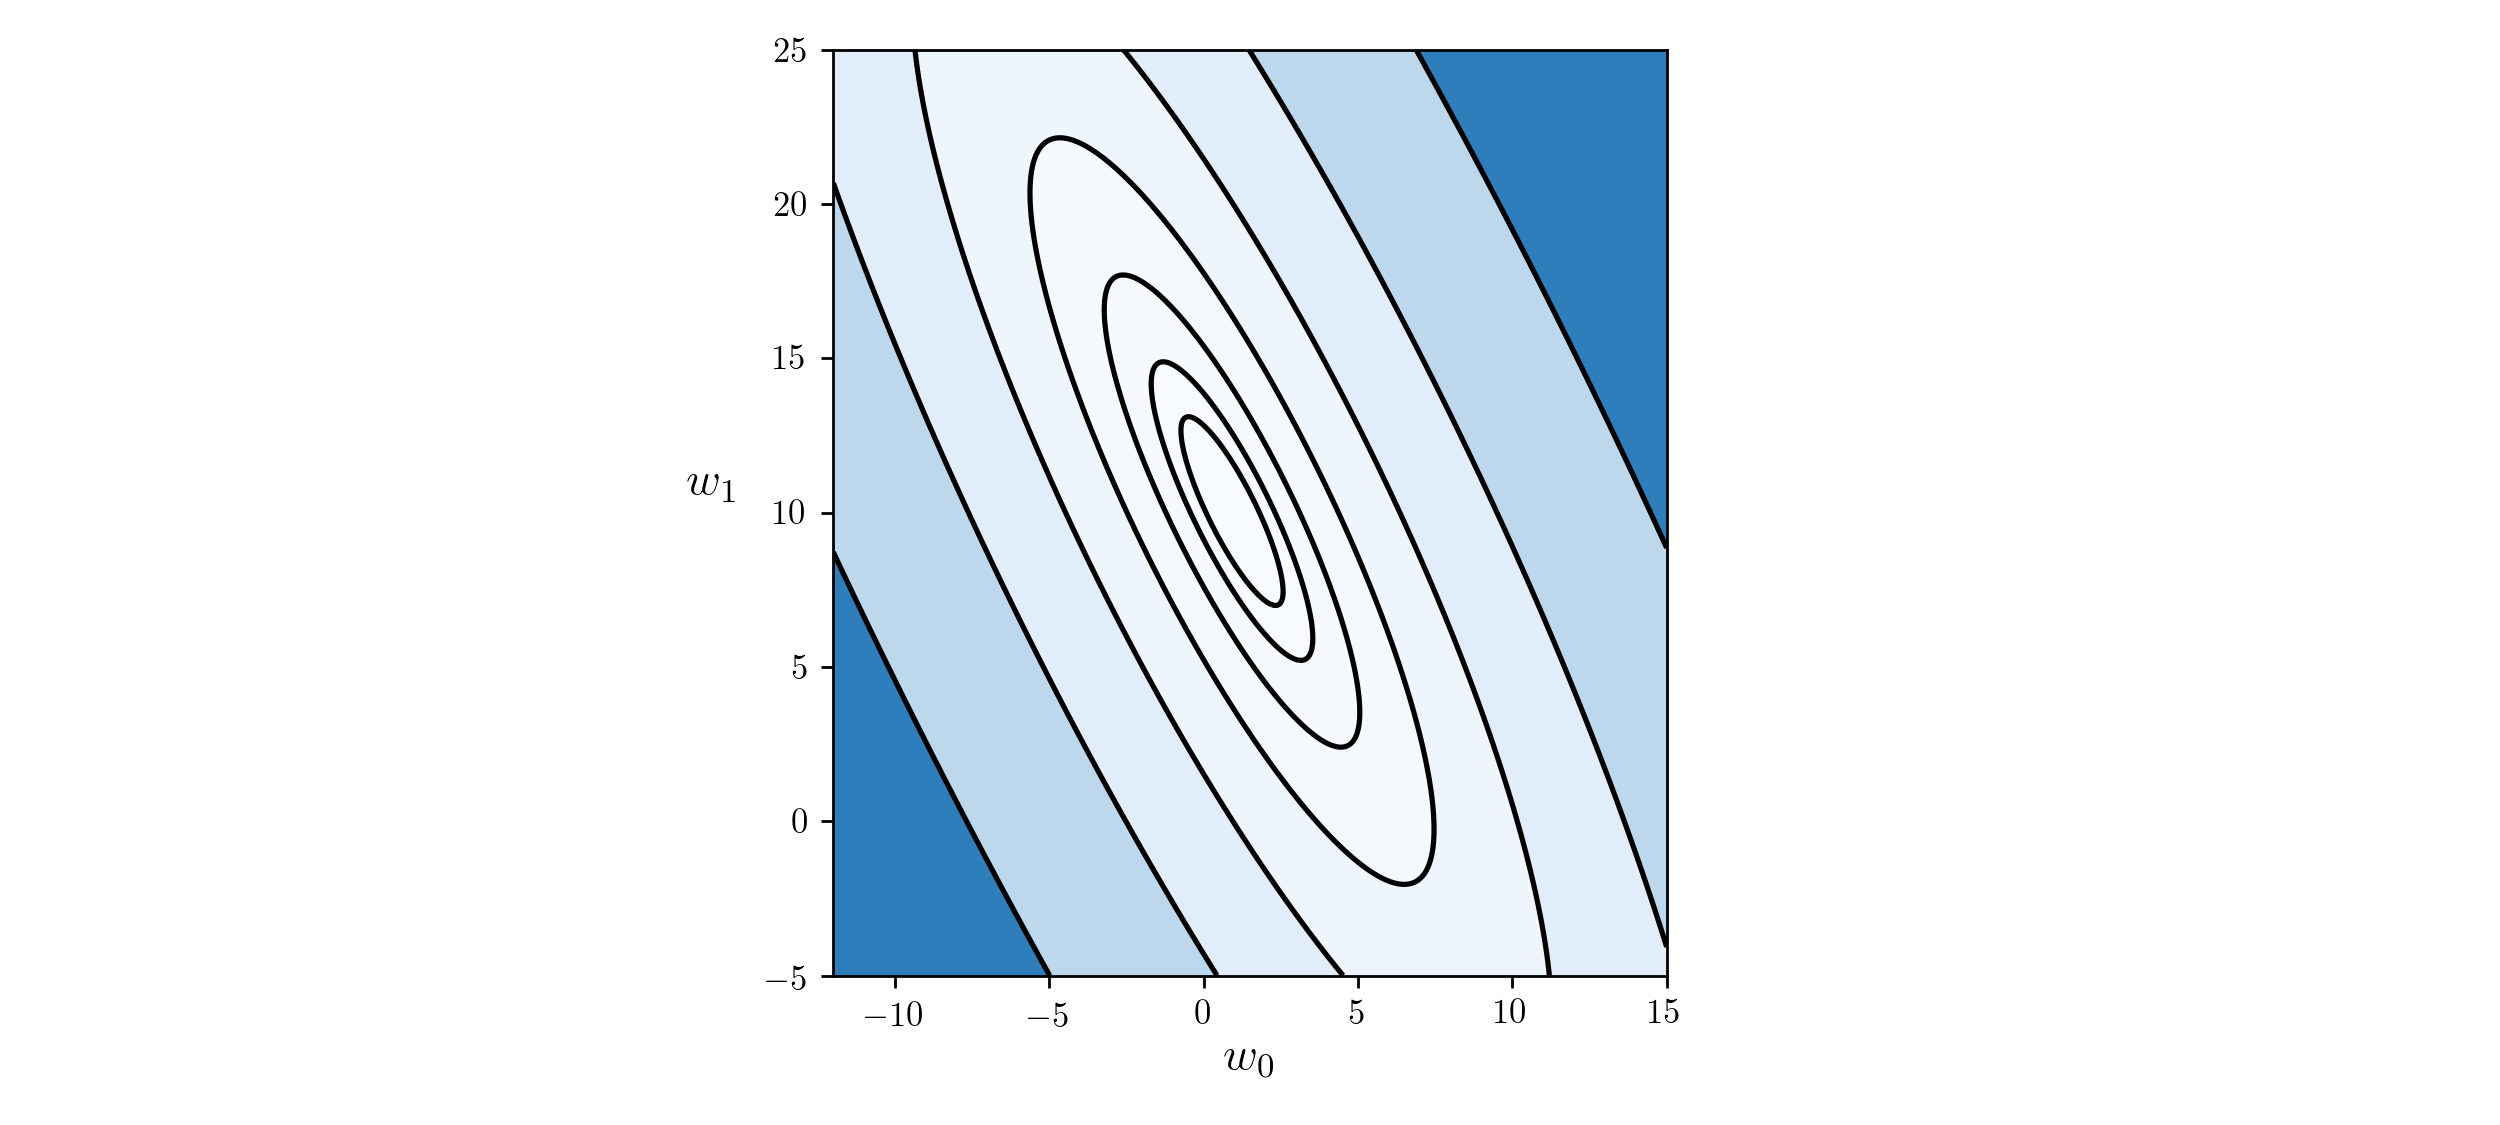

In [4]:
# show the contours of an input function over a desired viewing range
static_plotter.two_input_contour_plot(least_squares,[],xmin = -12,xmax = 15,ymin = -5,ymax = 25,num_contours = 7,show_original = False)

- contours very **elliptical** 

- these create a long narrow valley along the long axis of the ellipses

- as discussed in Section 6.4 gradient descent progresses quite slowly when applied to minimize a cost functions like this

In [5]:
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; w = np.array([0.0,0.0])[:,np.newaxis]; max_its = 100; alpha_choice = 10**(-1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

- make a run of $100$ steps of gradient descent

<IPython.core.display.Javascript object>


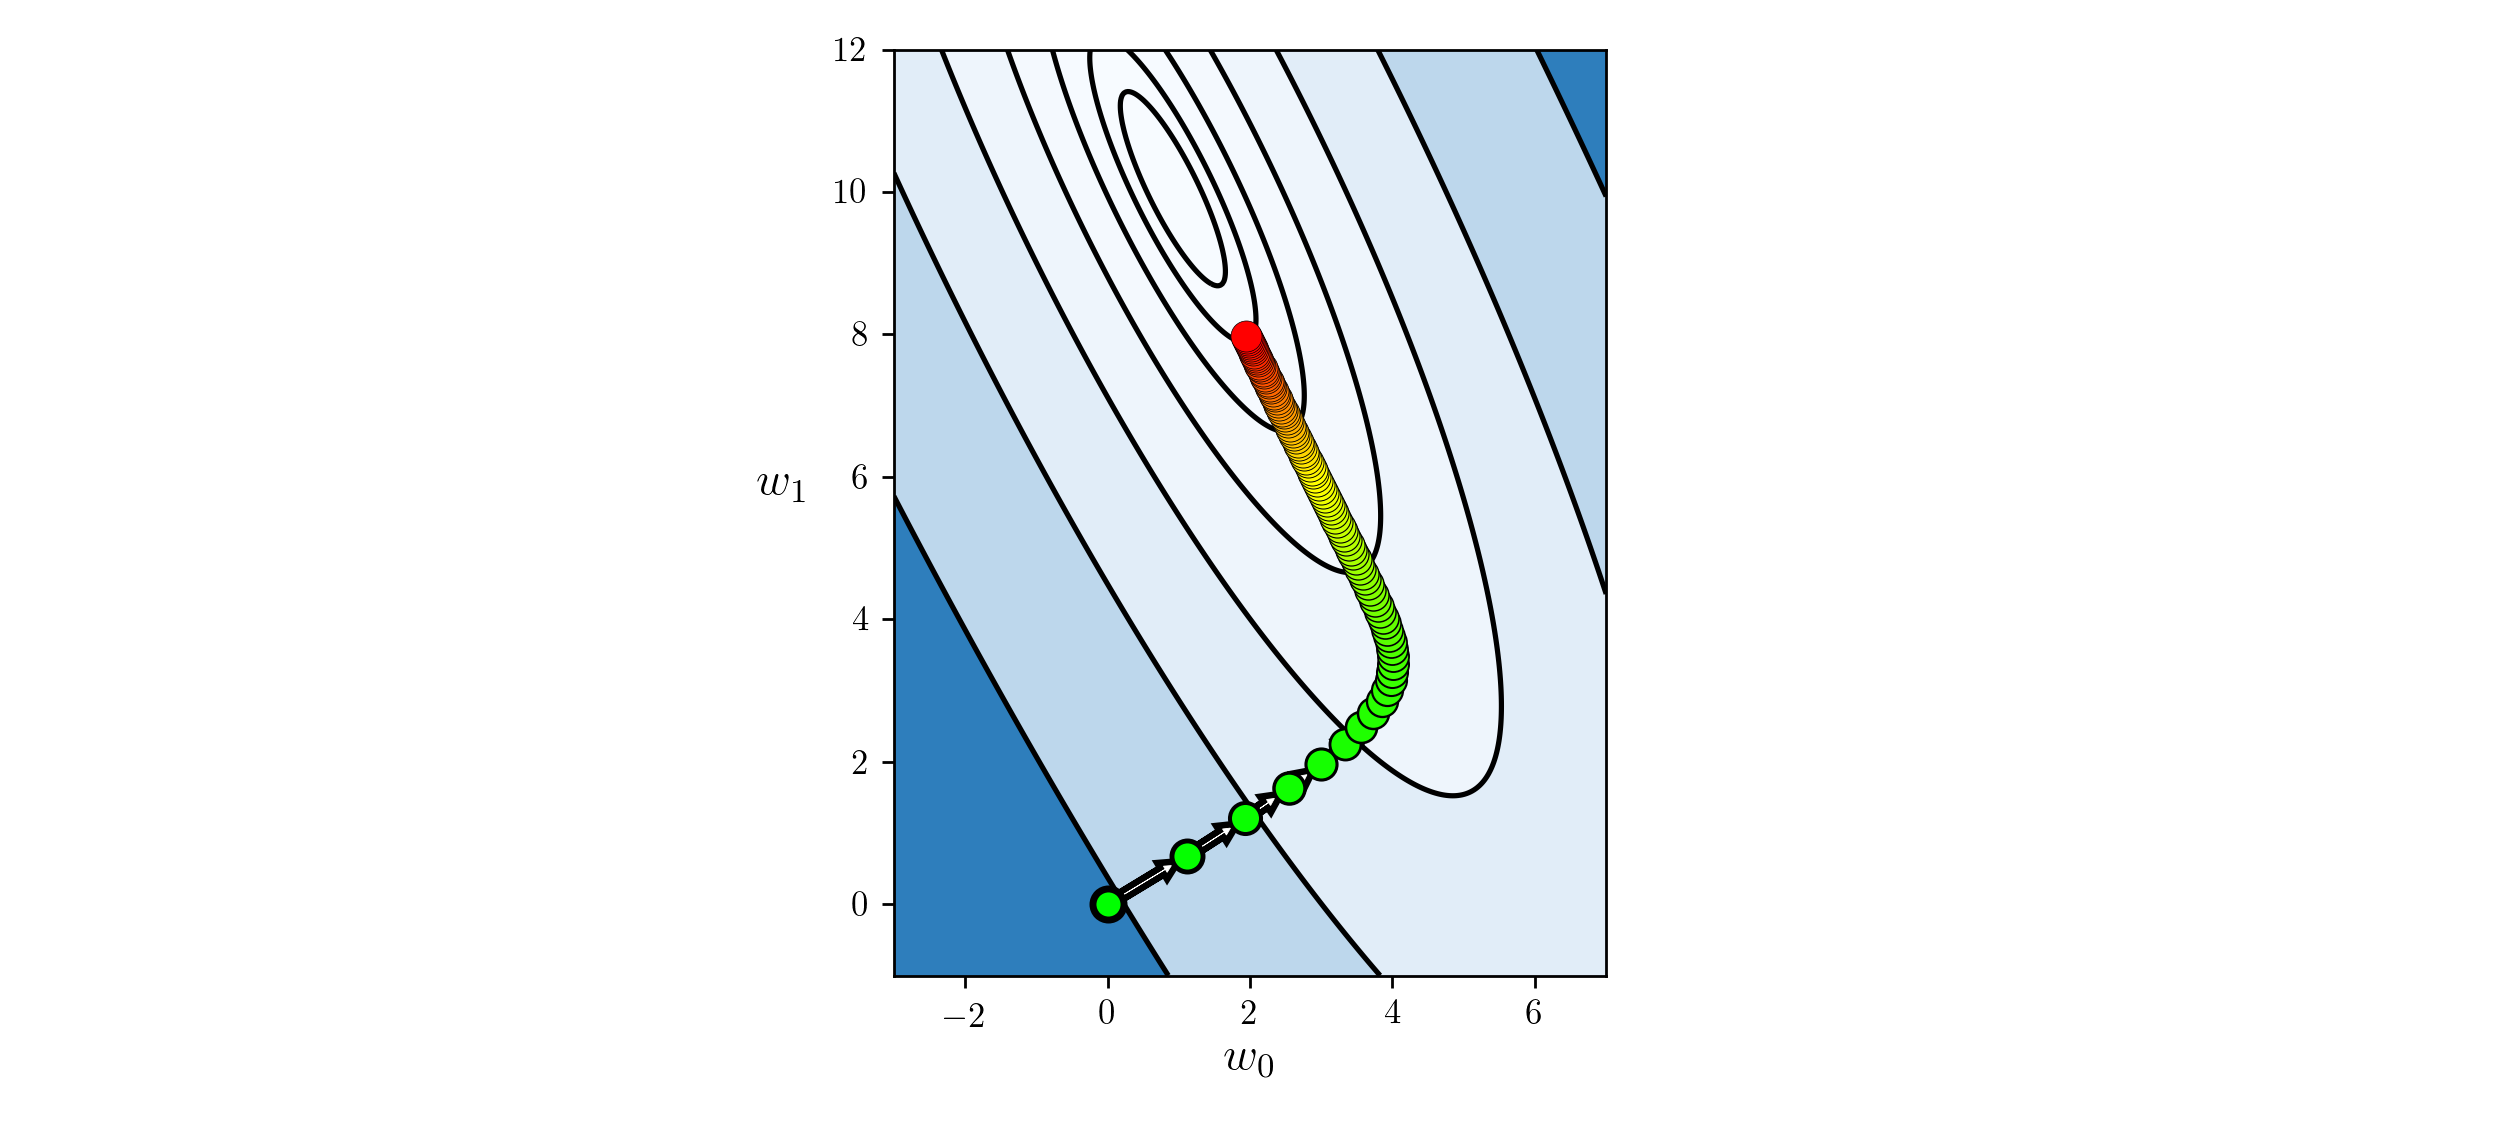

In [6]:
# show run on contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -3,xmax = 7,ymin = -1,ymax = 12,num_contours = 7,show_original = False)

- little progress made in the long narrow valley of the function!

- the resulting fit is therefore quite poor

<IPython.core.display.Javascript object>


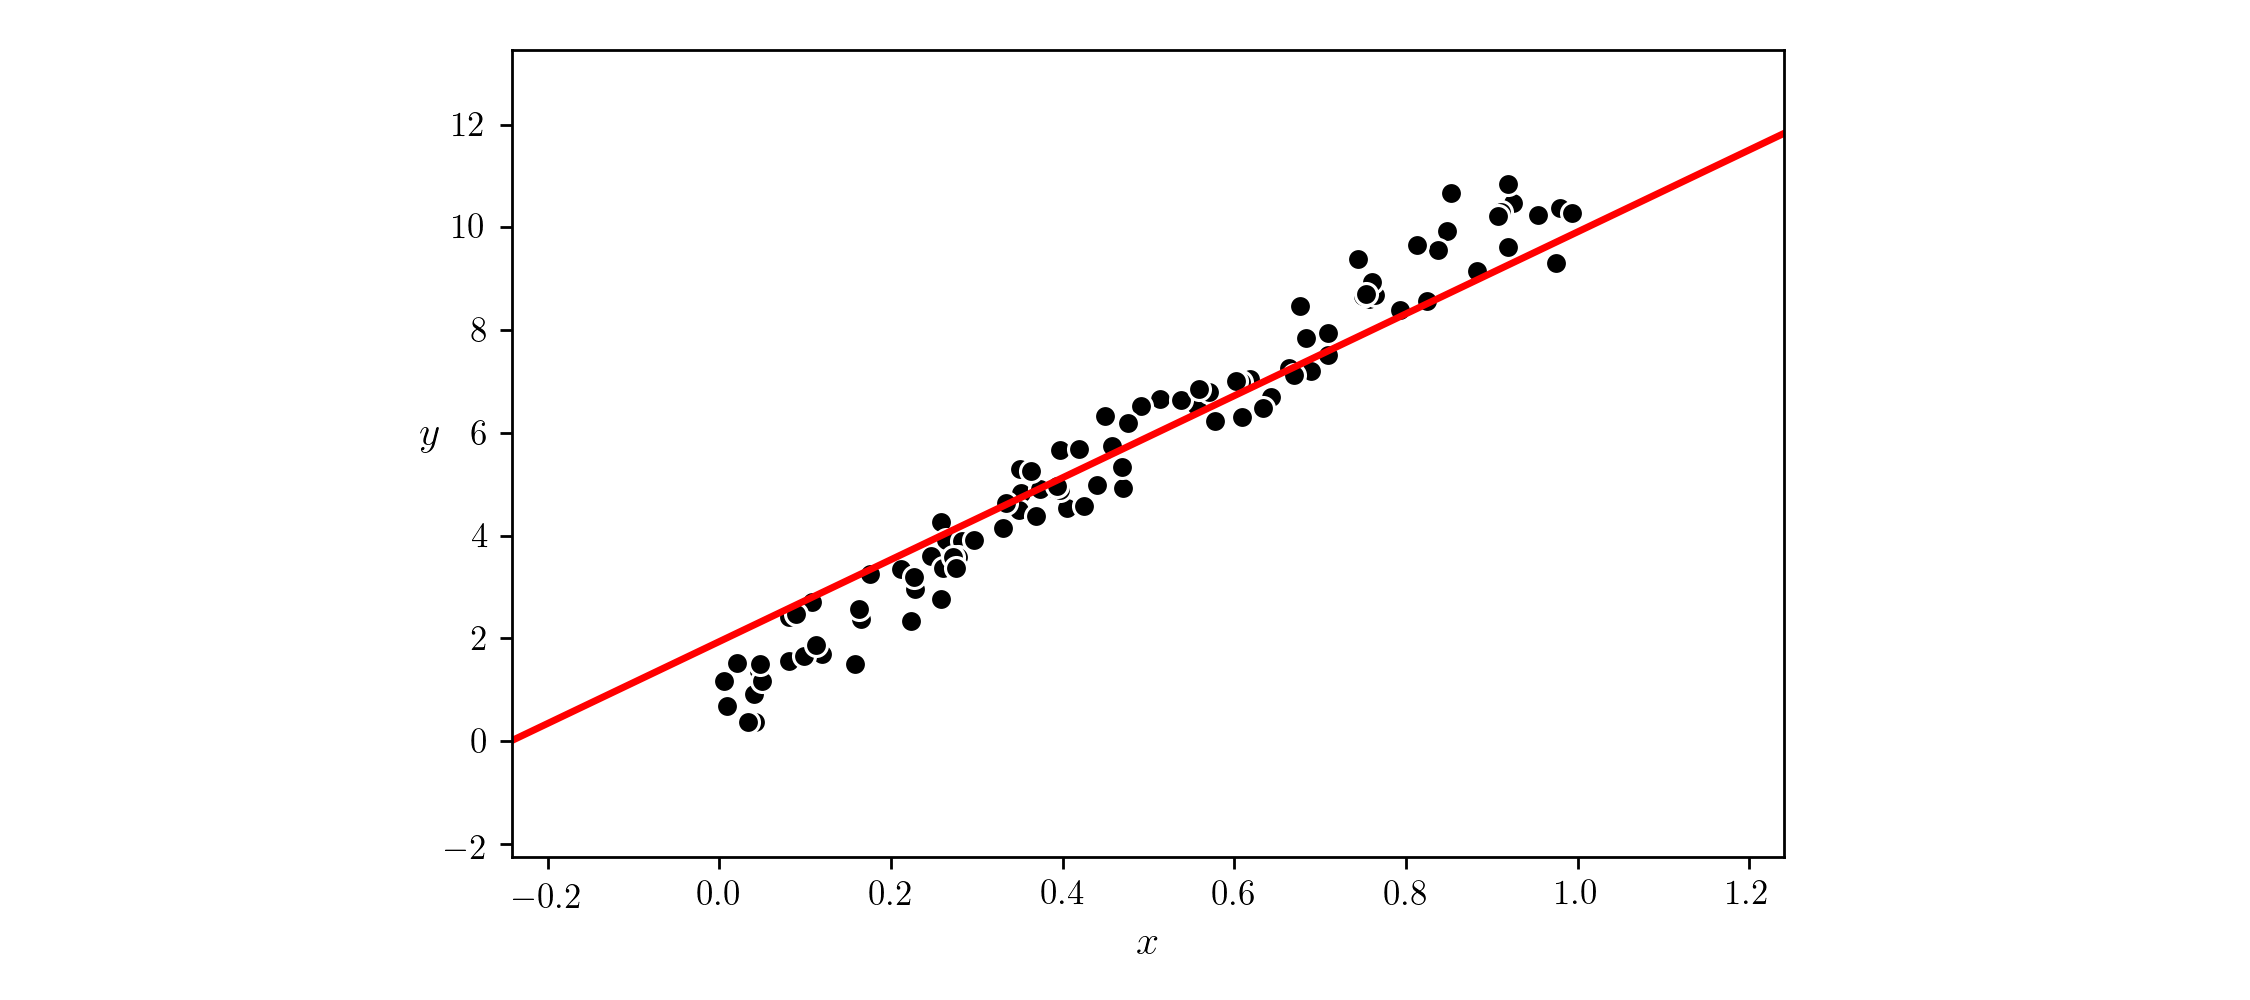

In [7]:
# the original data and best fit line learned from our gradient descent run
ind = np.argmin(cost_history)
least_weights = weight_history[ind]
demo.plot_fit(plotting_weights = [least_weights],colors = ['r'])

- an extremely simple adjustment of the data ameliorates this issue significantly, called *standard normalization*

- do the following to each input dimension / feature: subtract mean and divide off standard deviation

- for single input case, we replace each input $x_p$ point with its mean centered unit deviation analog as 

\begin{equation}
x_p \longleftarrow \frac{x_p - \mu}{\sigma}
\end{equation}

where

\begin{equation}
\mu = \frac{1}{P}\sum_{p=1}^{P}x_p \\
\end{equation}

and the sample standard deviation of the inputs $\sigma$ is defined as 

\begin{array}
\
\sigma = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_p - \mu \right)^2}.
\end{array}

In [7]:
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # create standard normalizer function based on input data statistics
    normalizer = lambda data: (data - x_means)/x_stds
    
    # return normalizer and inverse_normalizer
    return normalizer

- super simple, invertible, and has a profound impact on the shape of our cost function 

- lets see what this does to the contours of the cost function we just saw

Now we form a Least Squares cost function with our normalized input, with the output un-changed.

In [10]:
# an implementation of the least squares cost function for linear regression, precisely
# what was shown in Section 8.1 but here pulled in from a backend file
least_squares_2 = cost_lib.choose_cost(x_normalized,y,'least_squares')

<IPython.core.display.Javascript object>


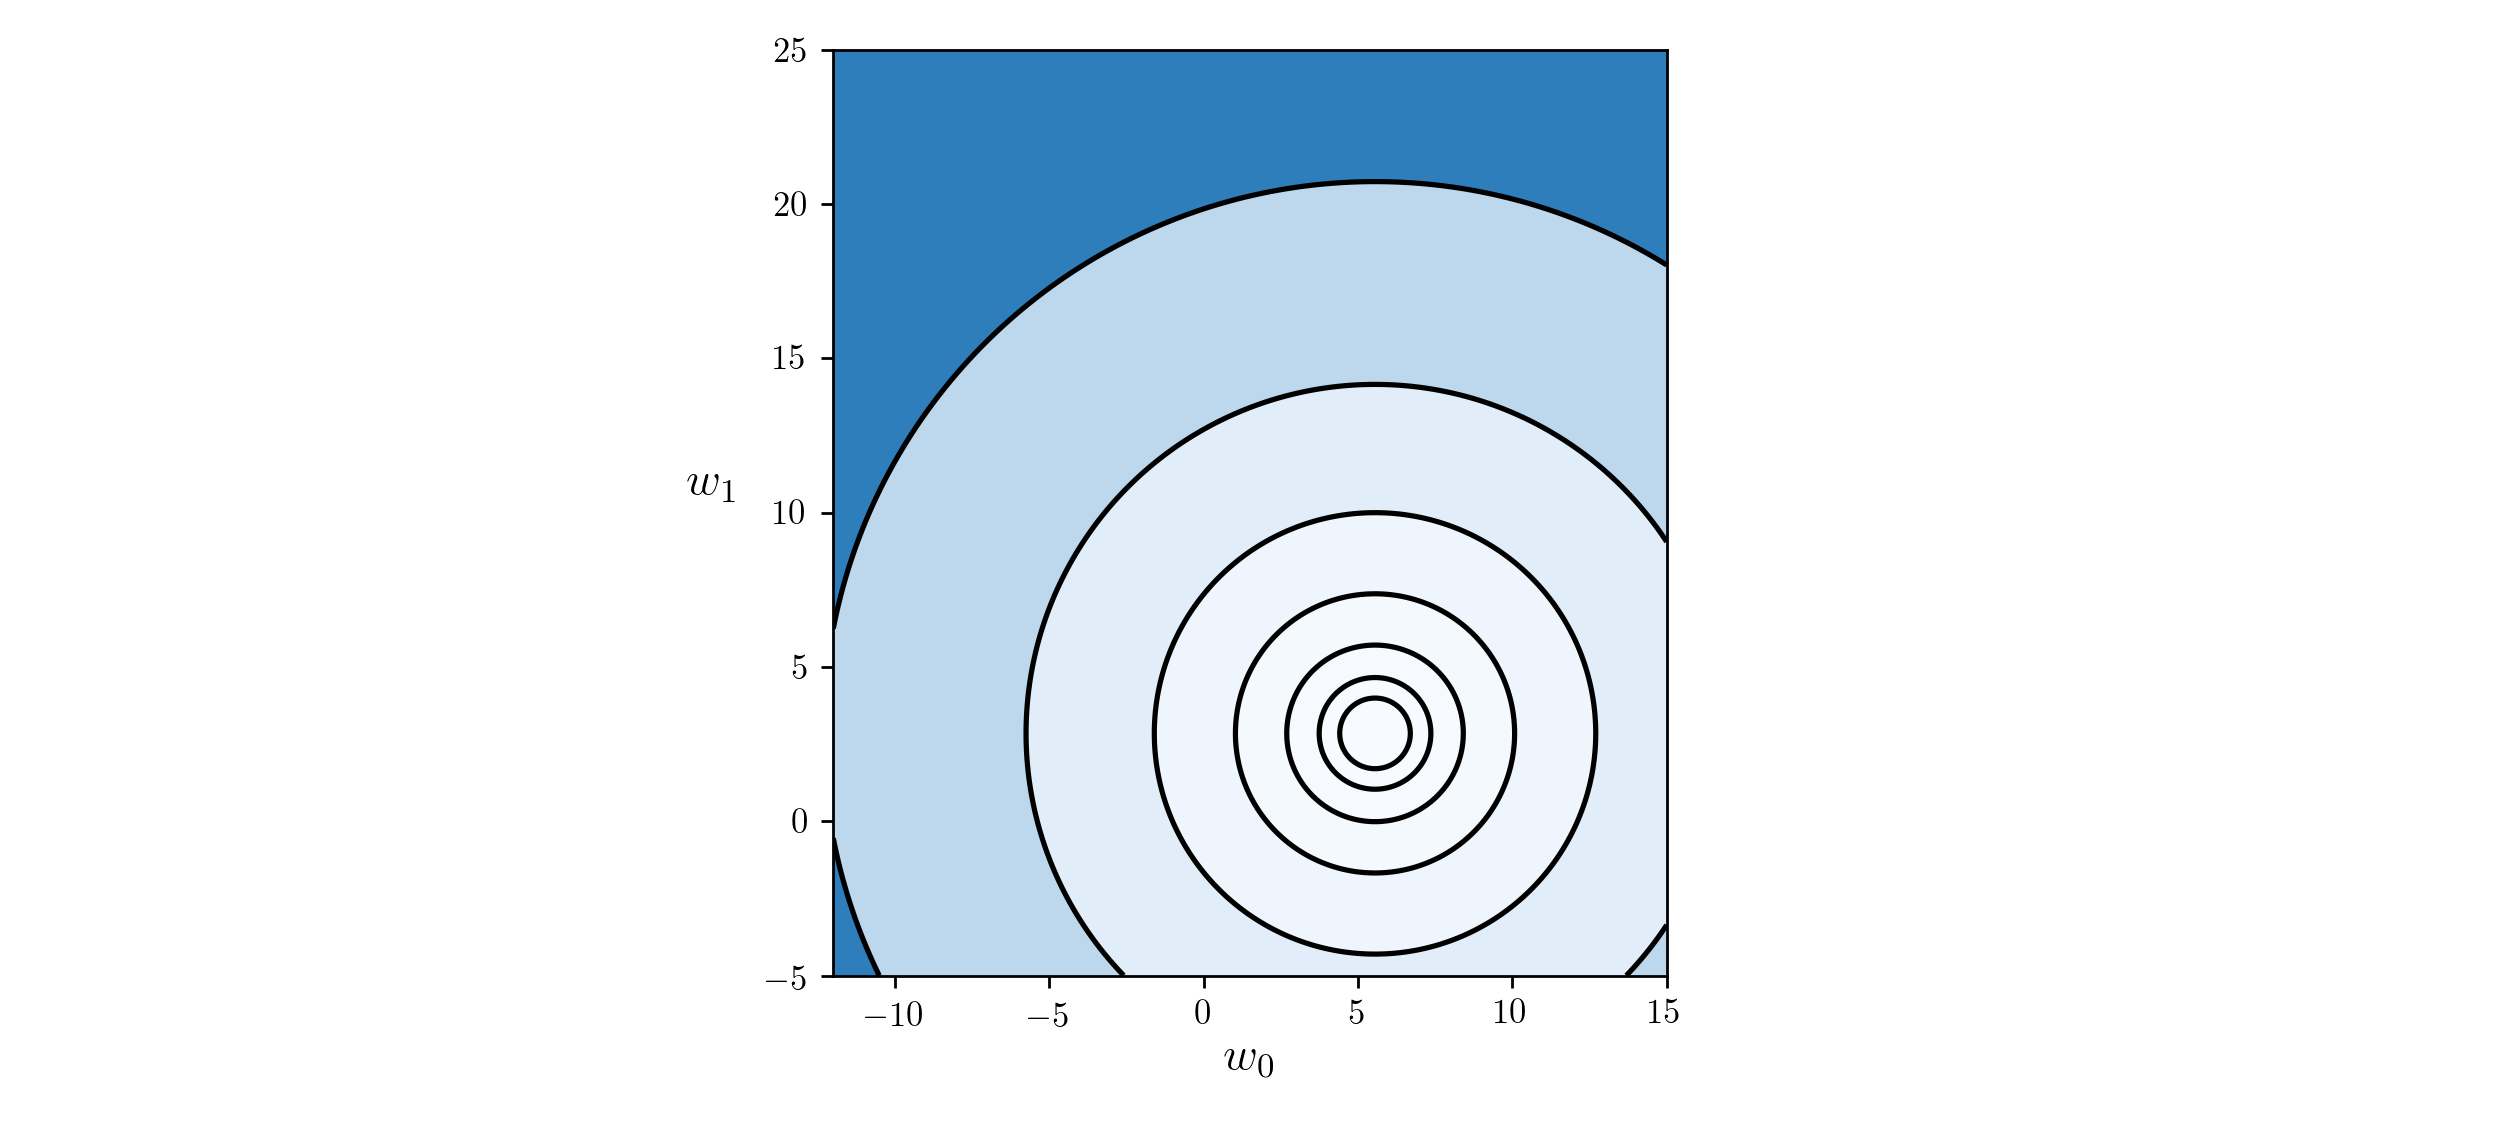

In [11]:
# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_contour_plot(least_squares_2,[],xmin = -12,xmax = 15,ymin = -5,ymax = 25,num_contours = 7,show_original = False)

- how did the cost function change?  lets look at an animation where we slide between the original and standard normalized data

- we will flip through versions of the cost function inputing

\begin{equation}
\left(1 - \lambda\right)x_p + \lambda \left( \frac{x_p - \mu}{\sigma} \right)
\end{equation}

where $\lambda$ ranges from $0$ (i.e., we use the original input) to $\lambda = 1$  


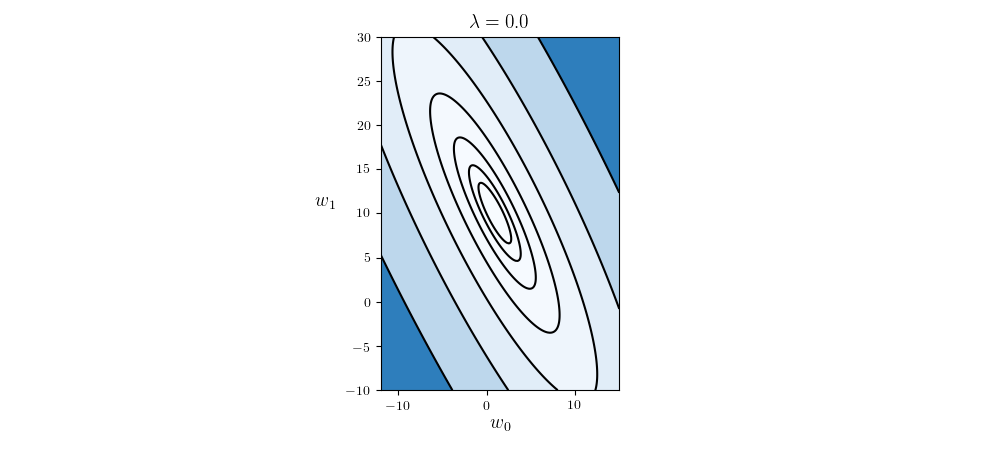
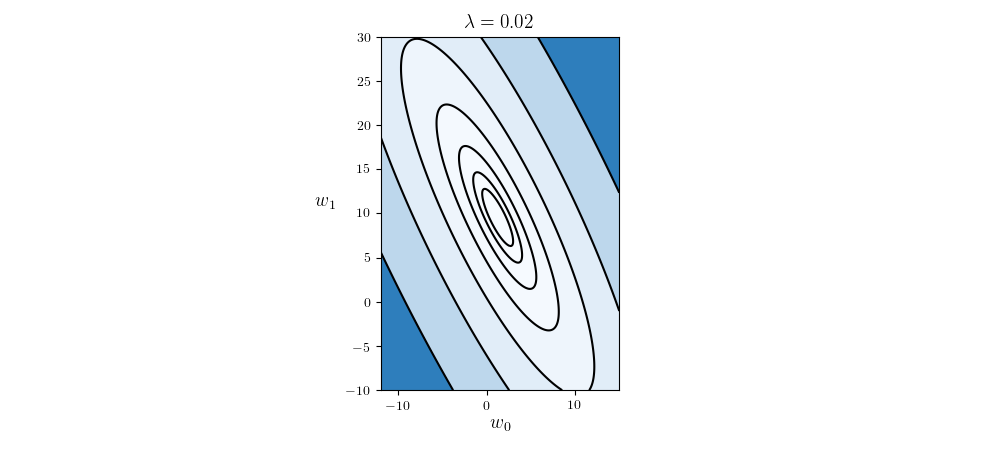
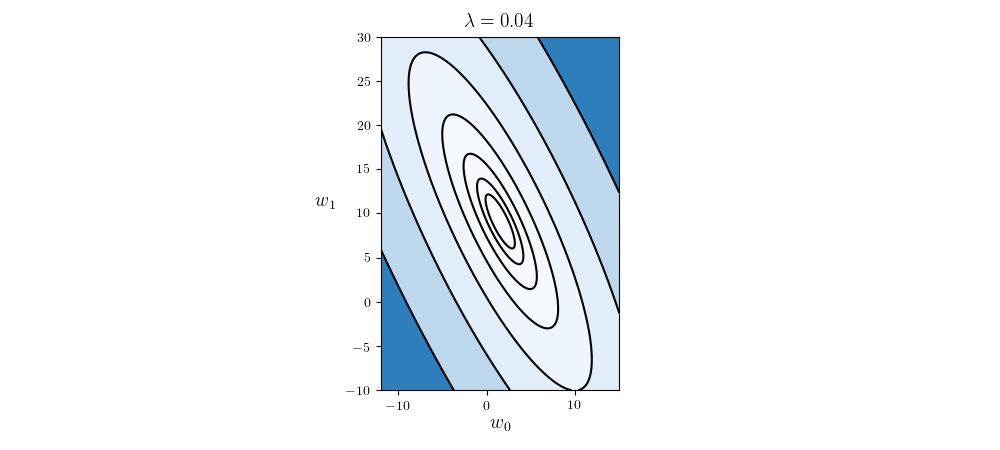
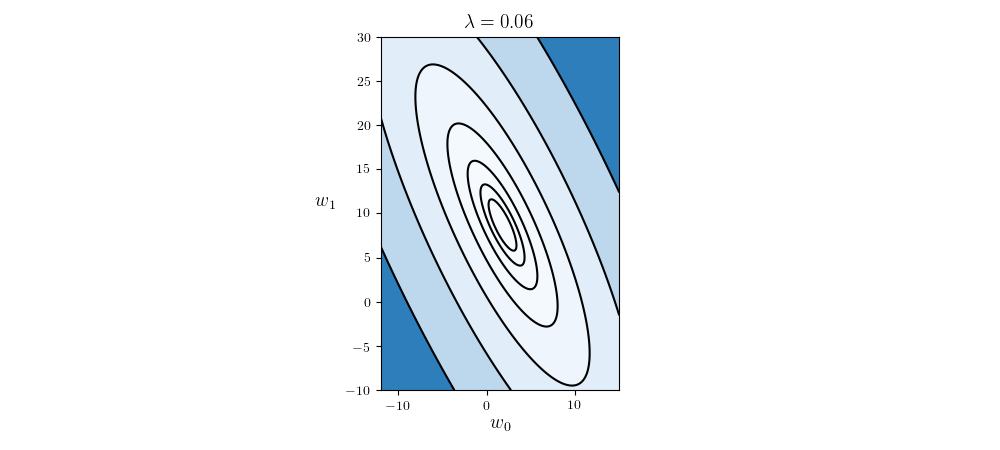
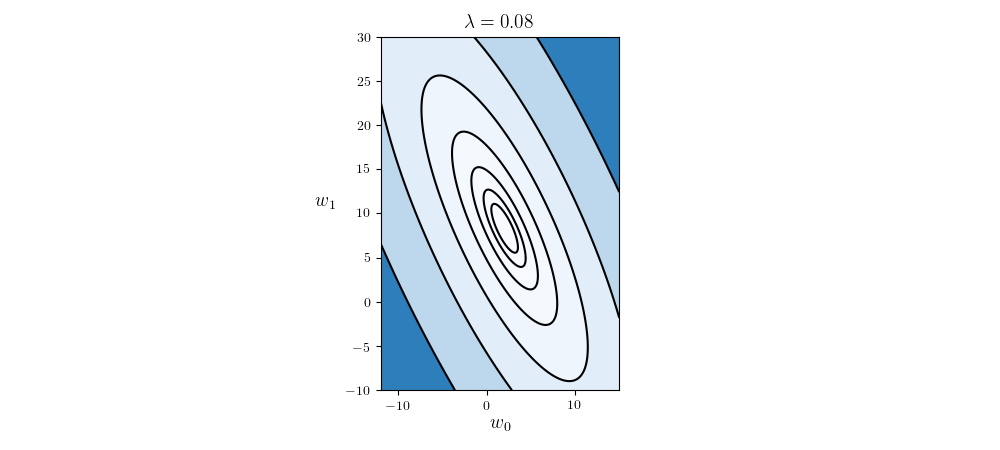
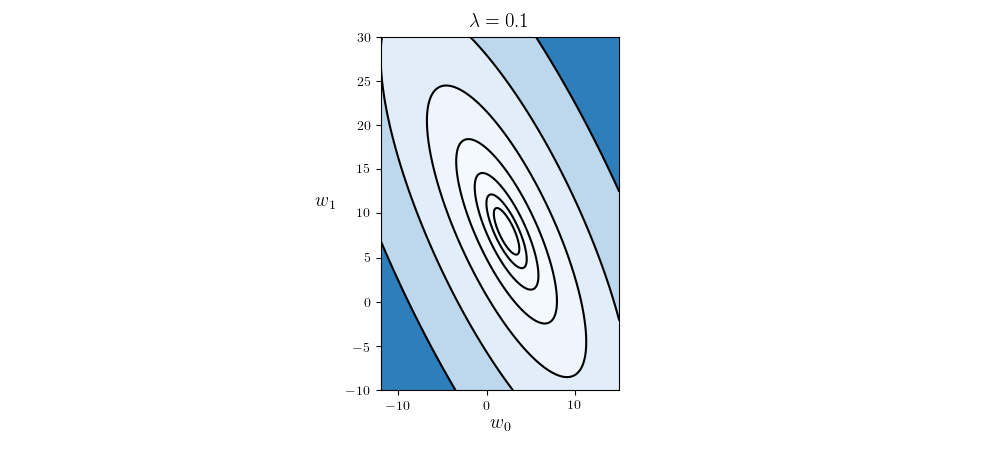
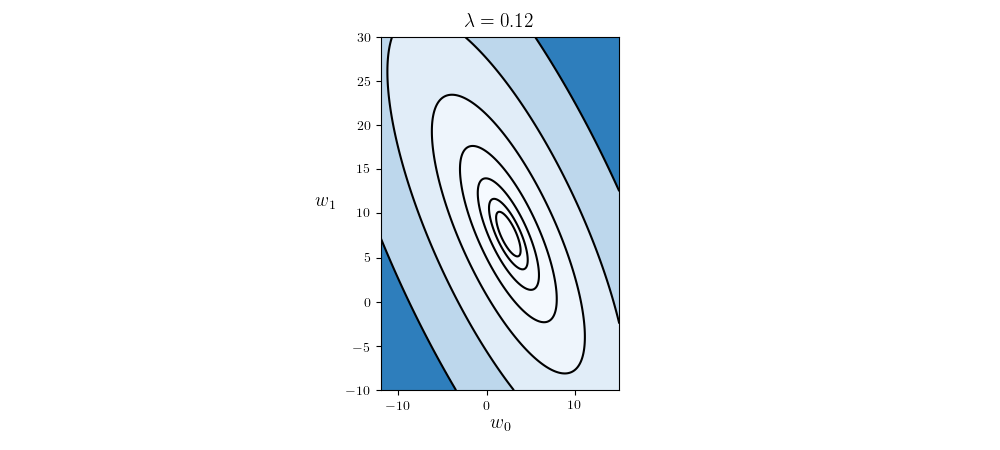
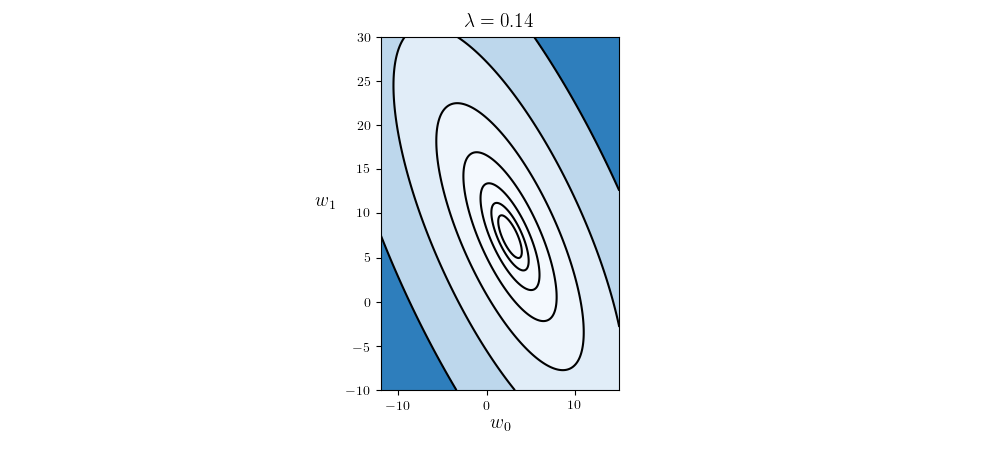
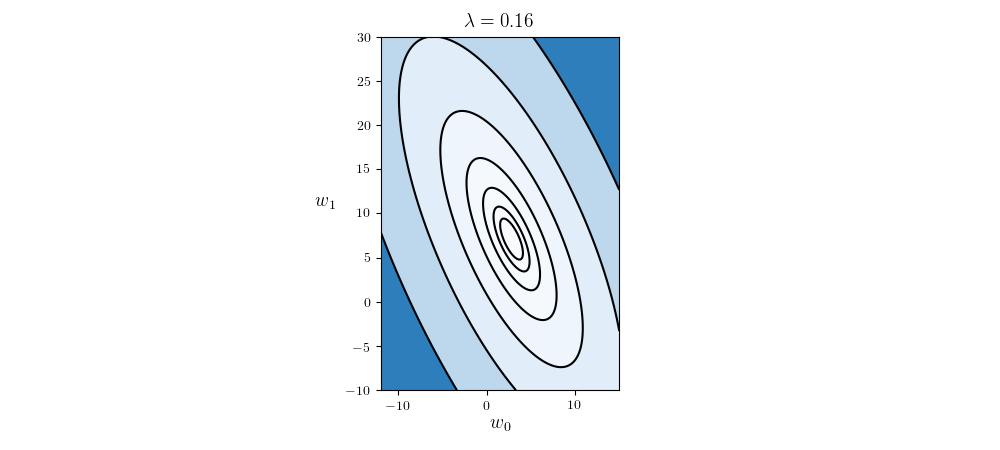
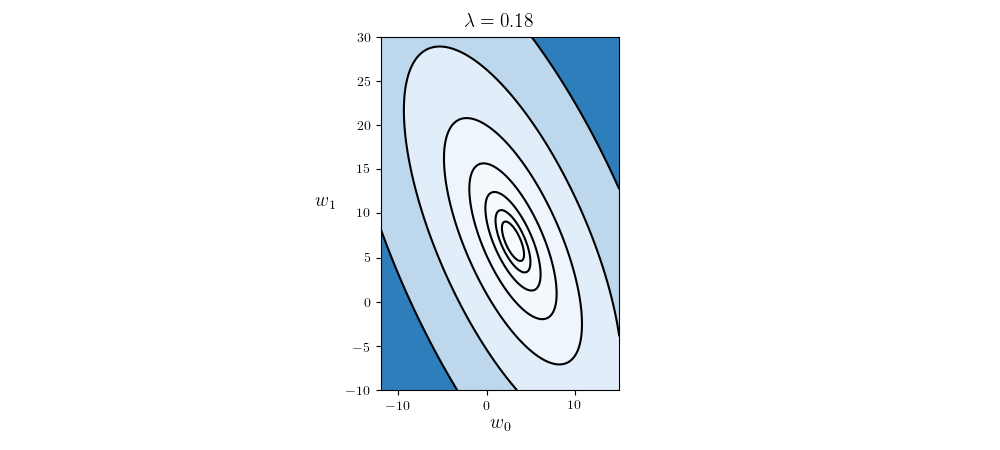
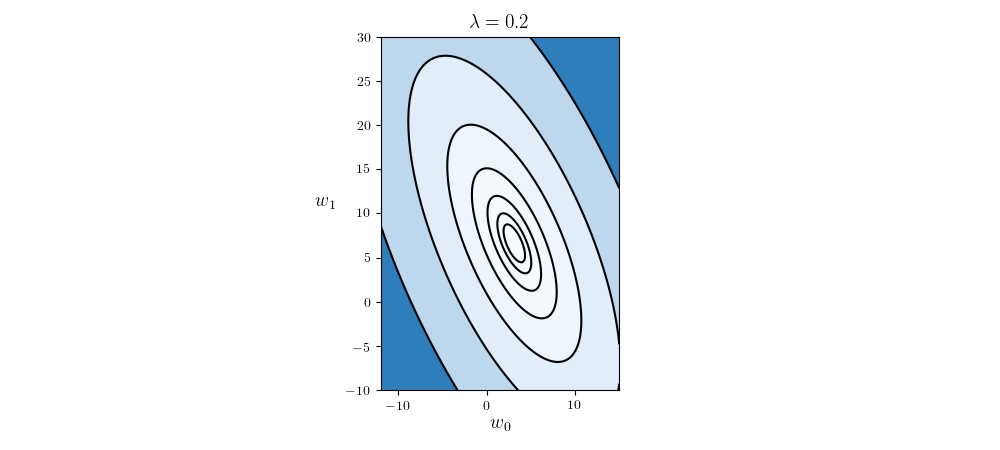
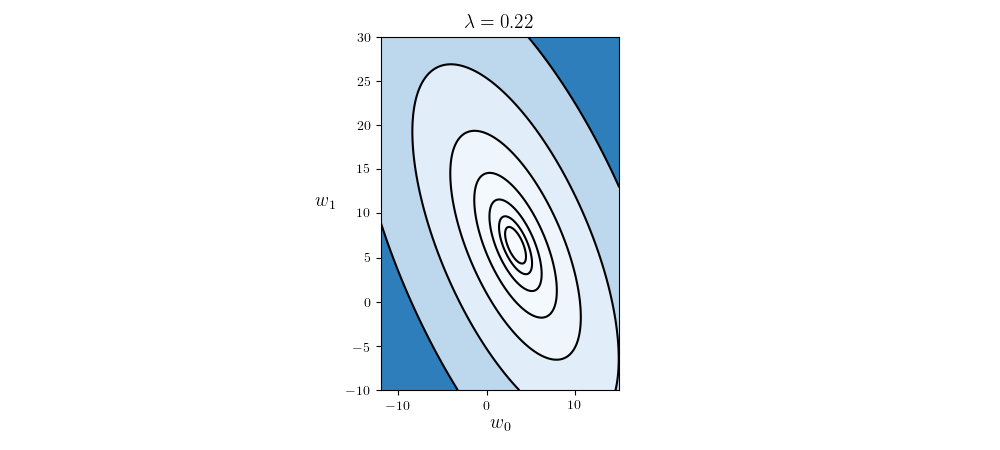
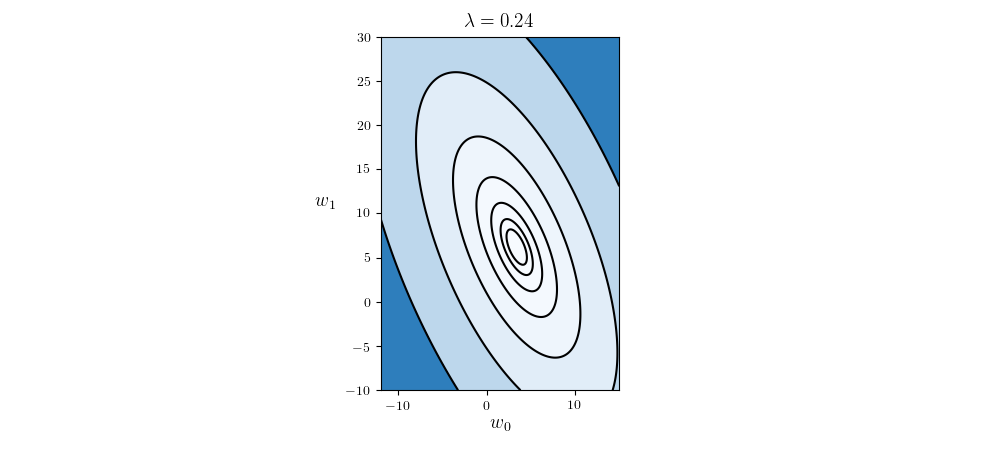
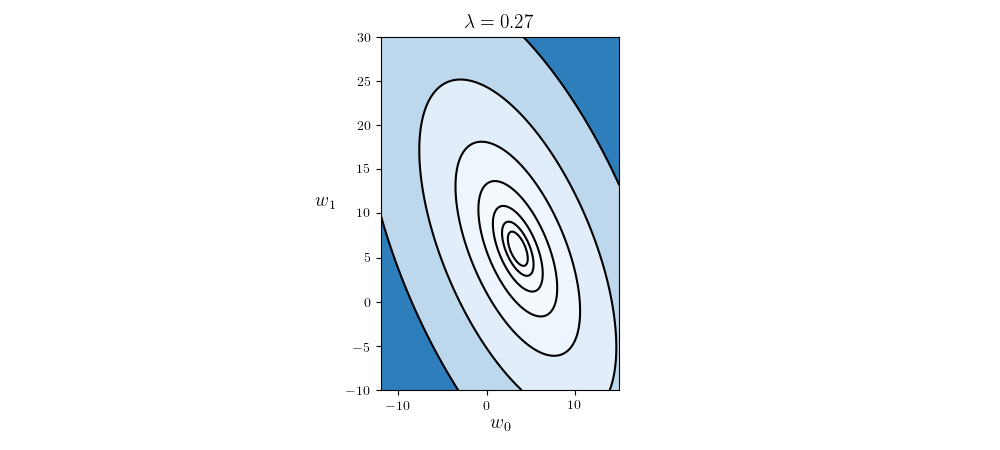
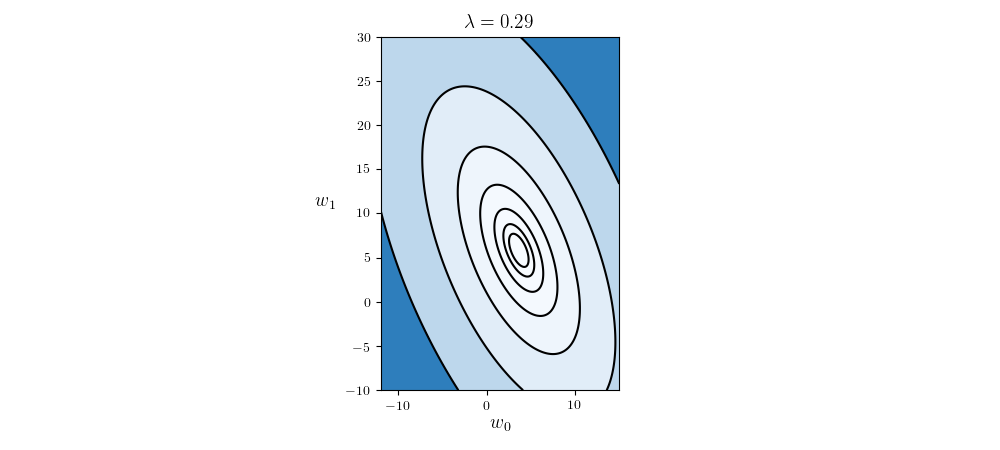
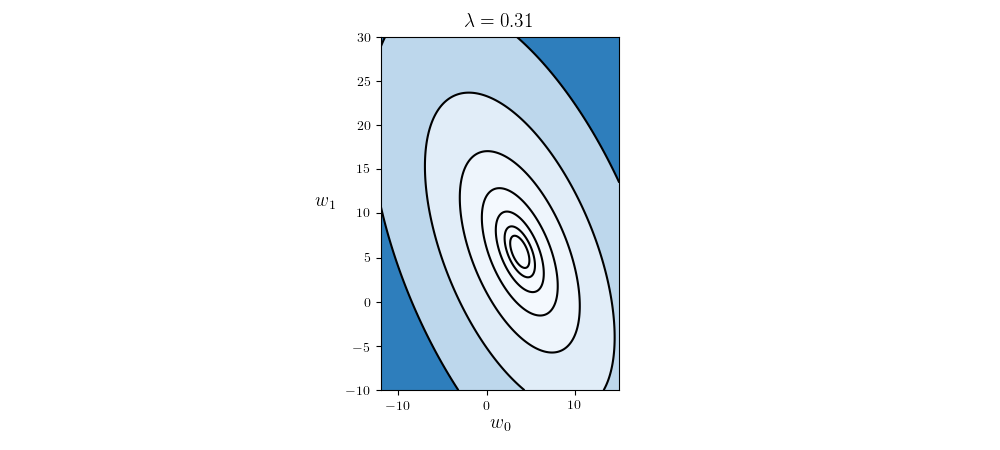
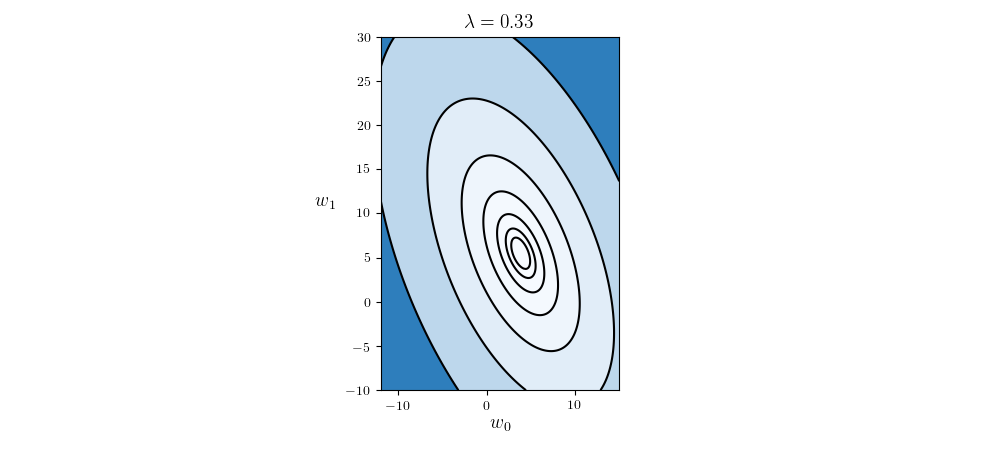
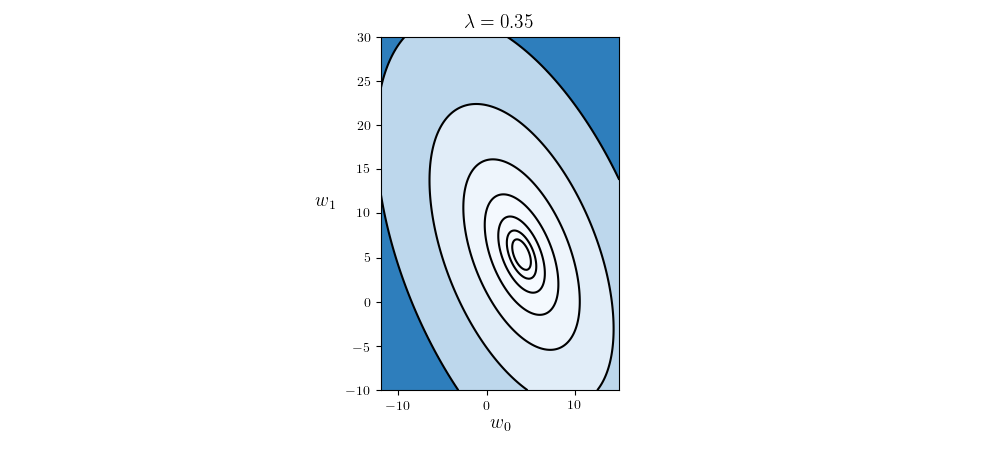
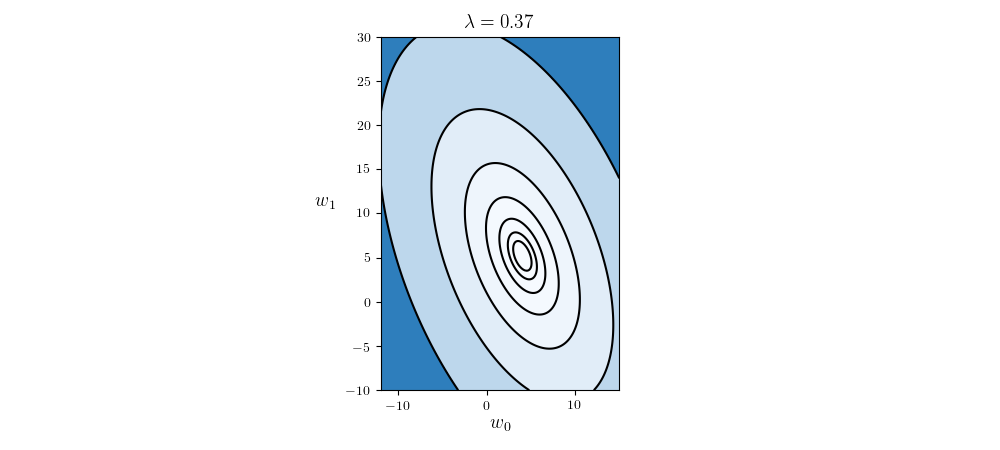
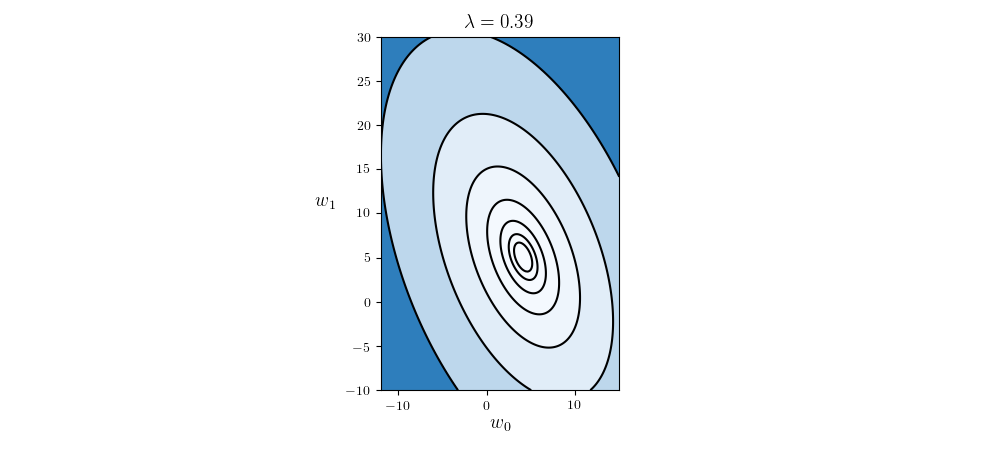
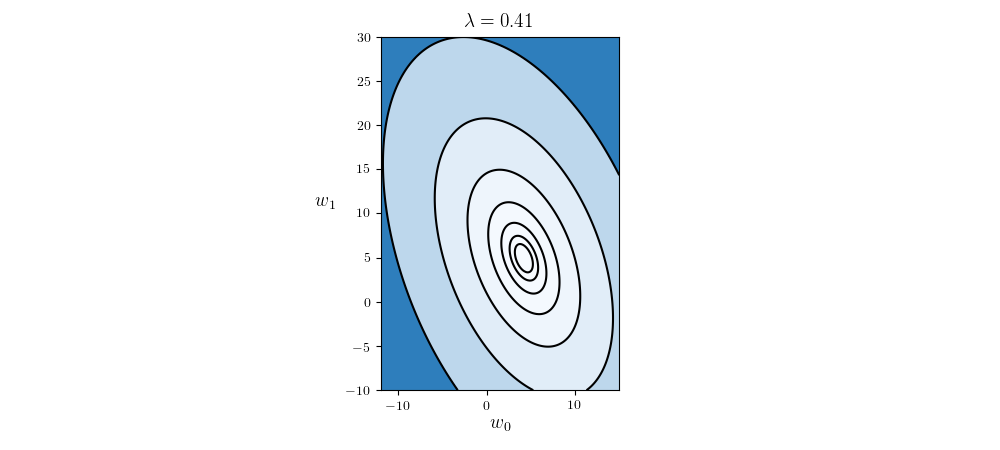
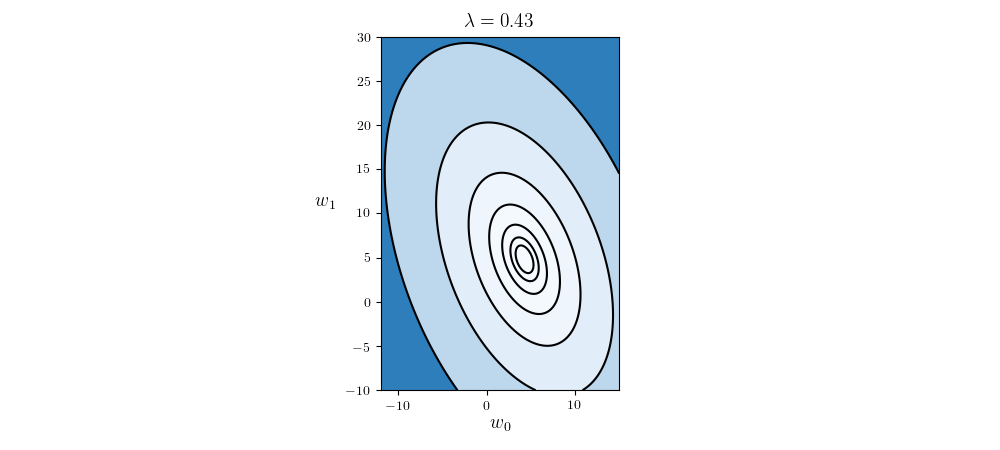
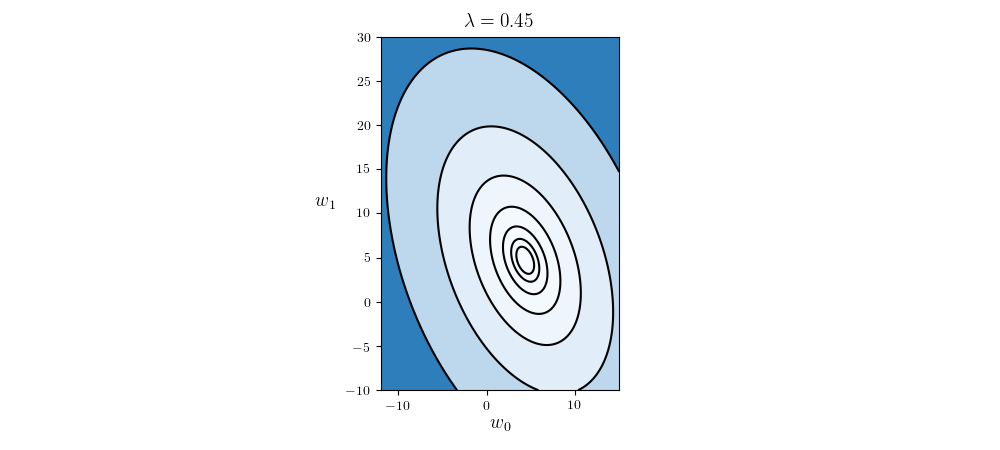
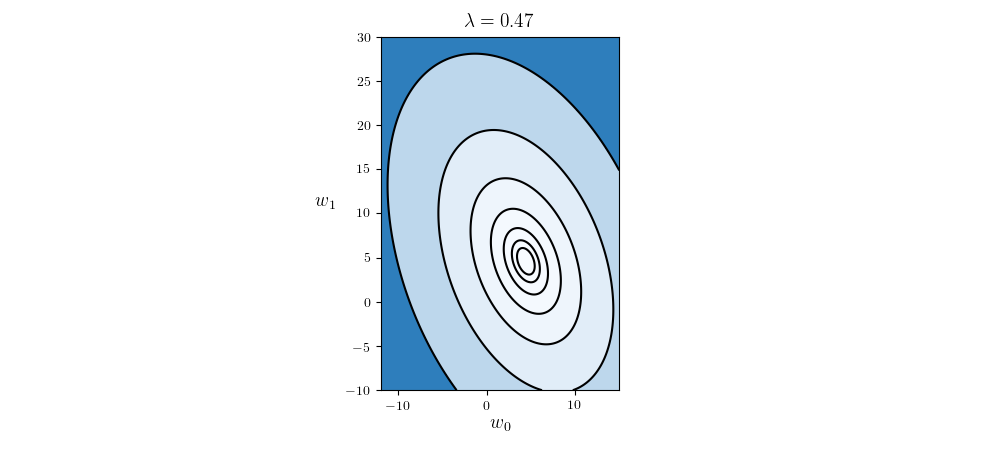
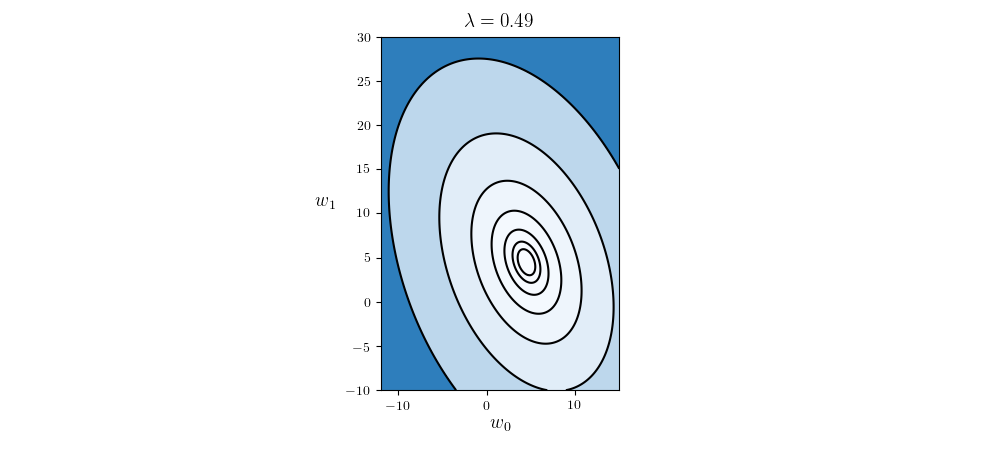
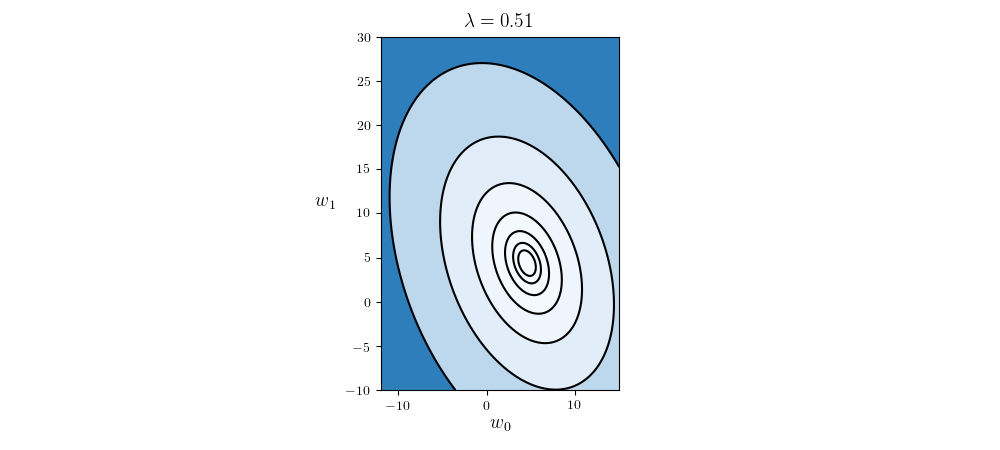
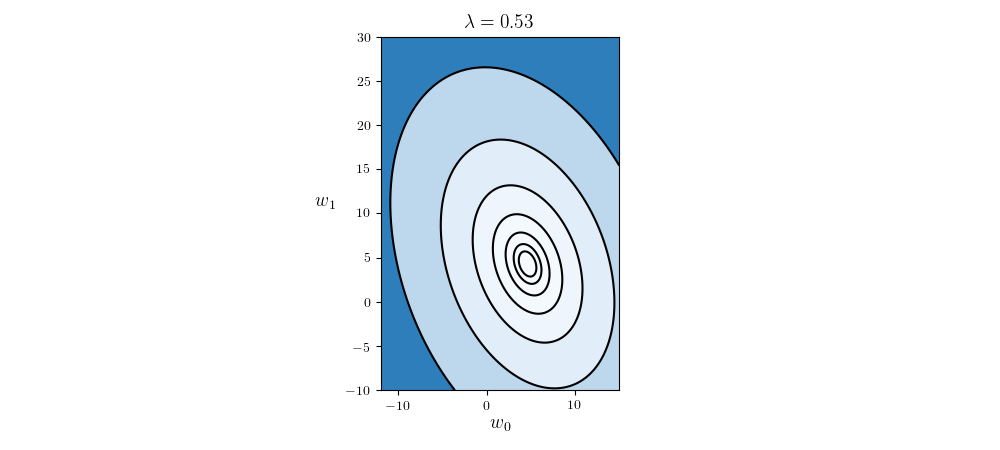
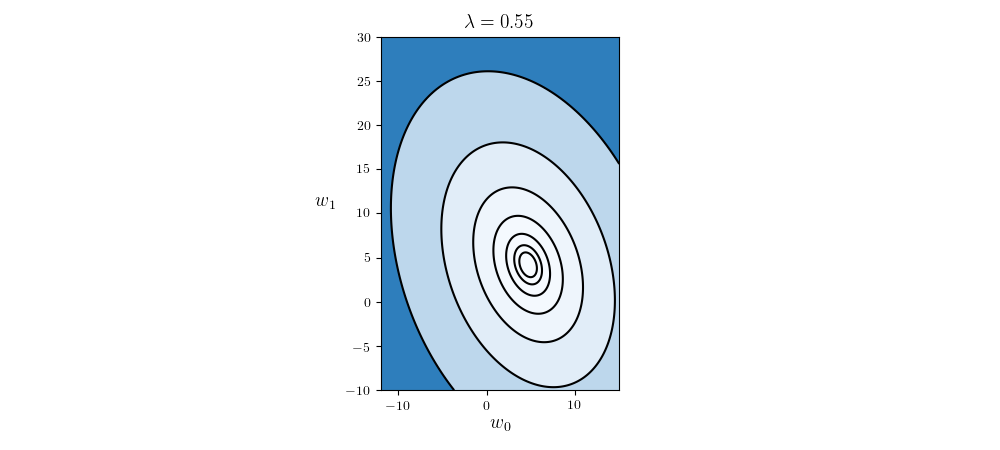
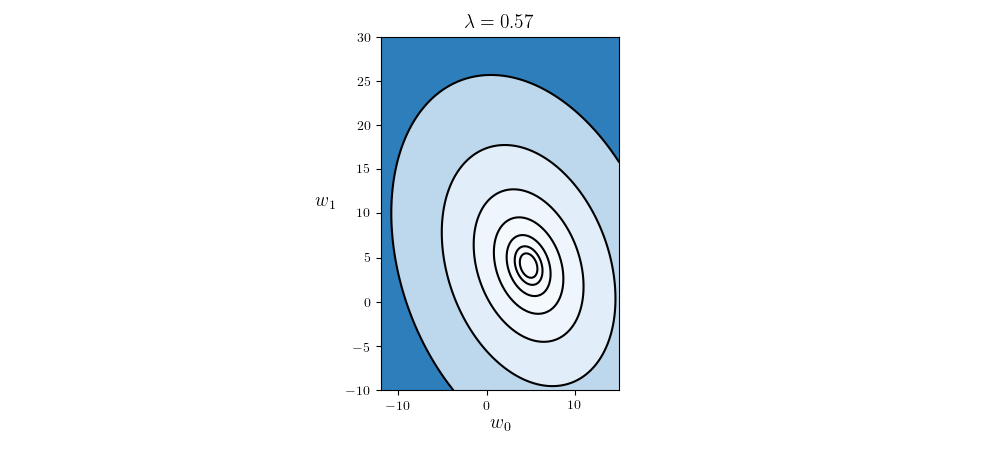
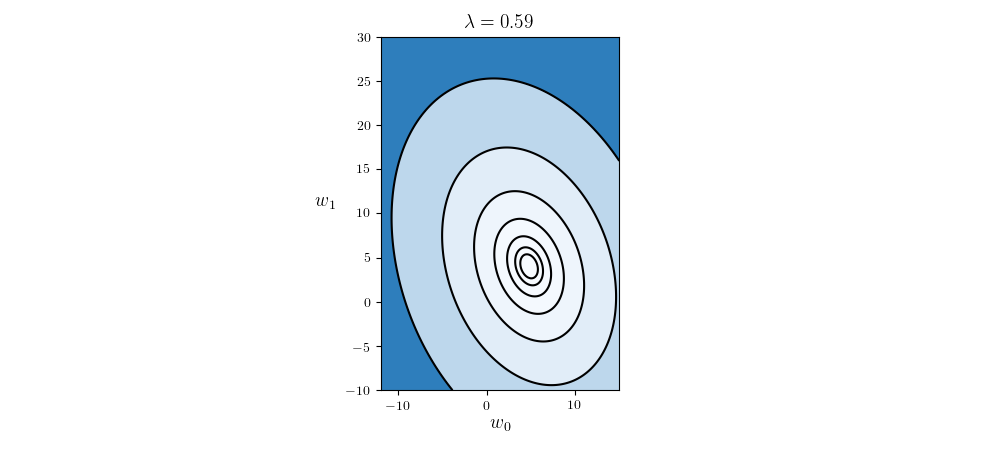
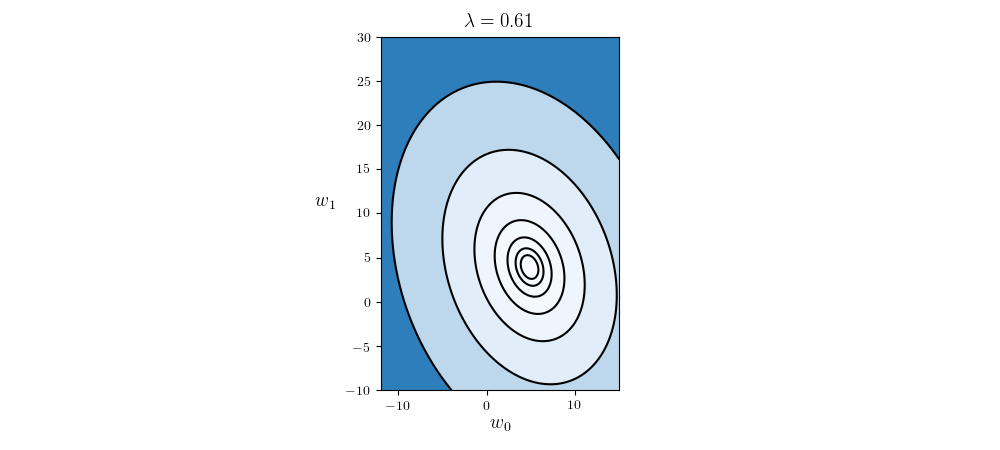
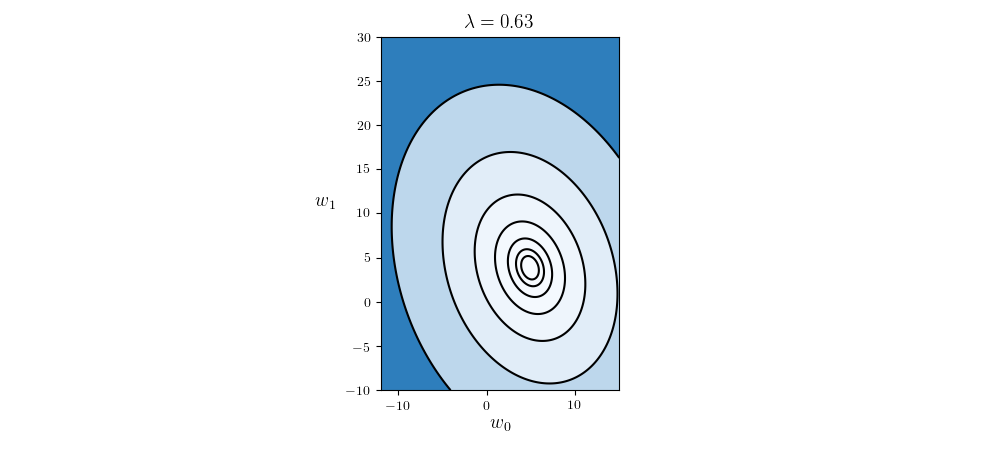
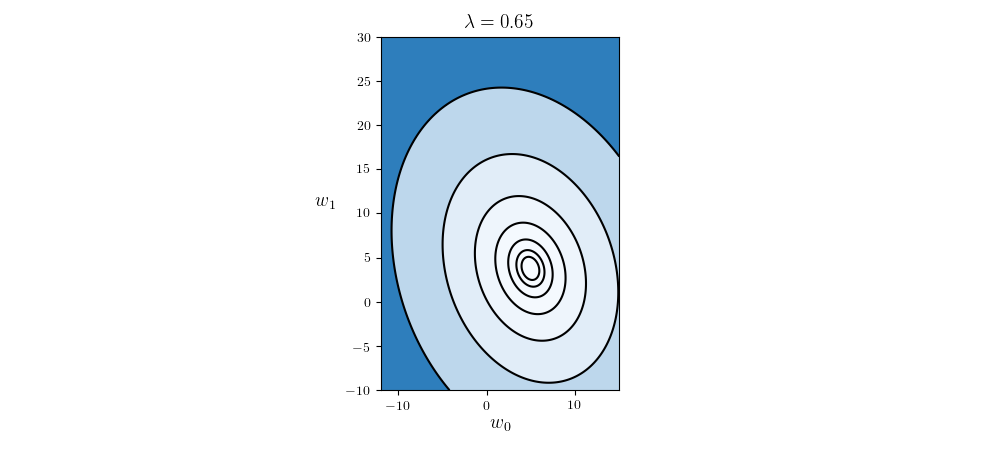
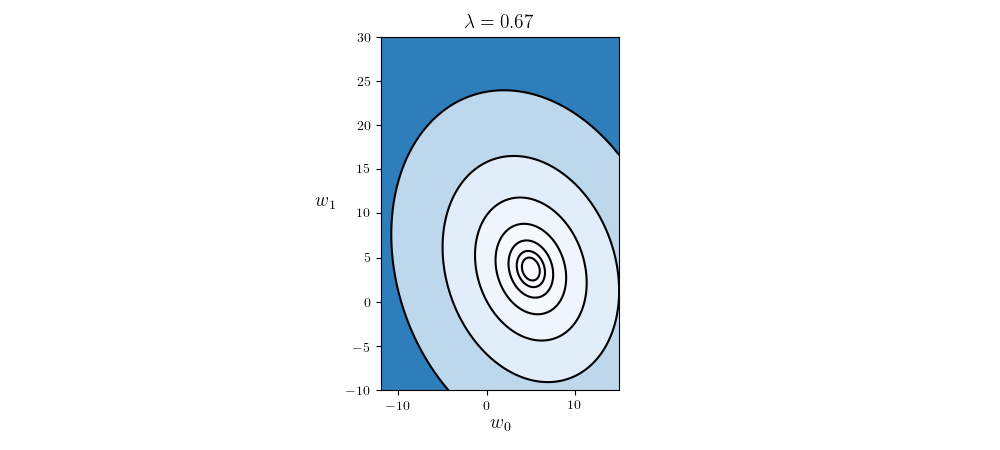
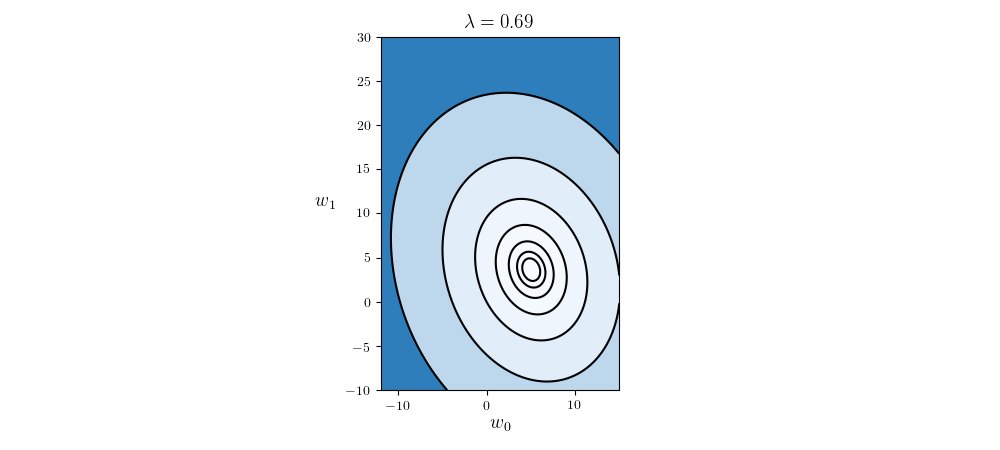
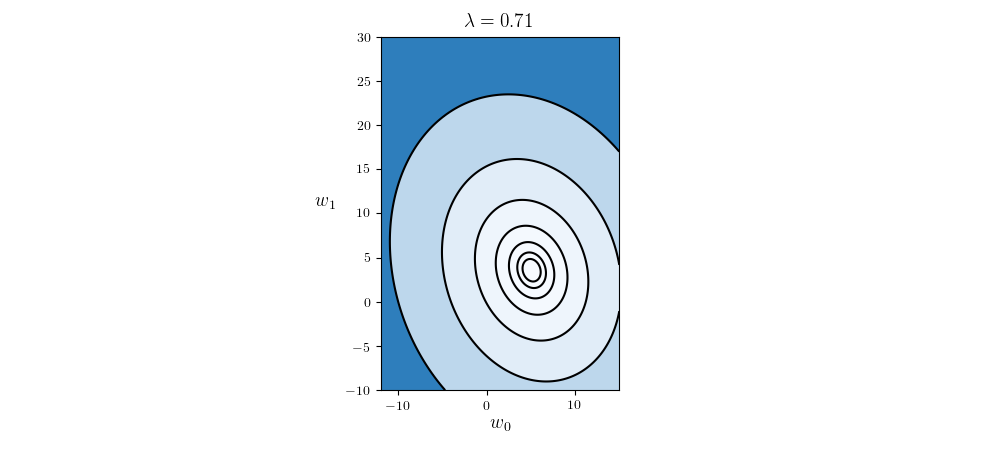
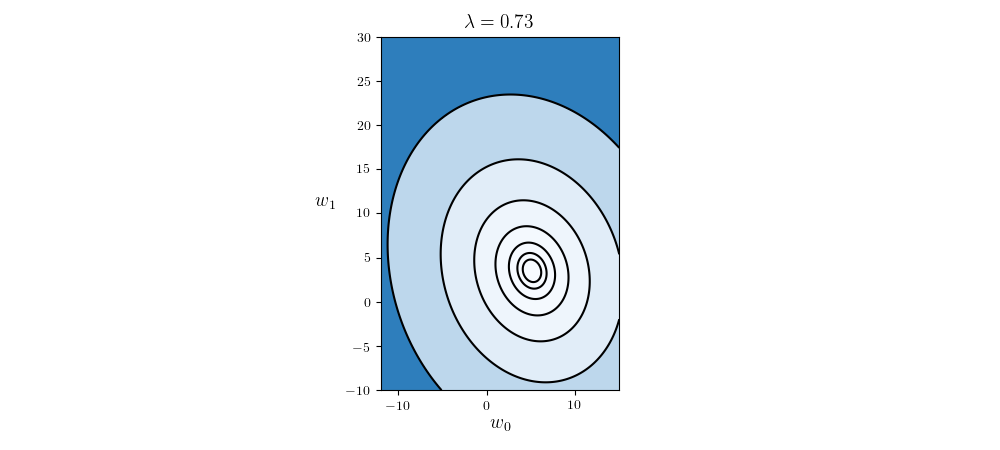
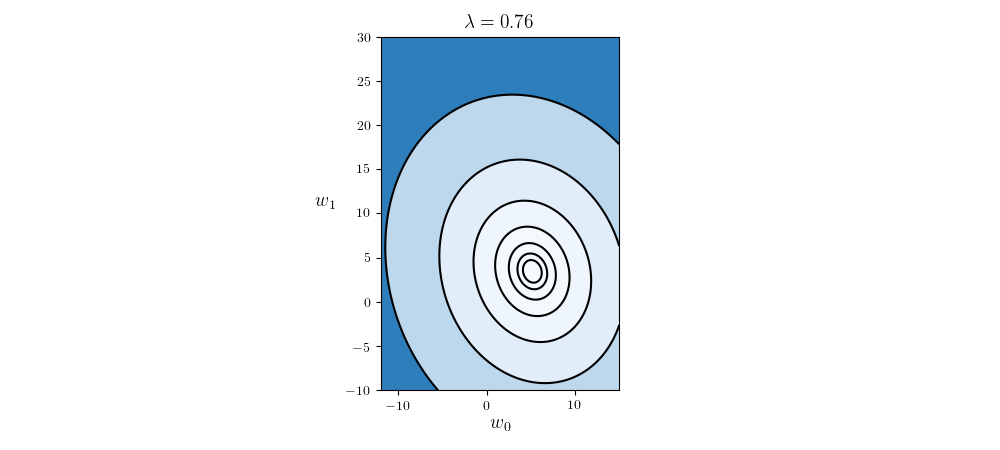
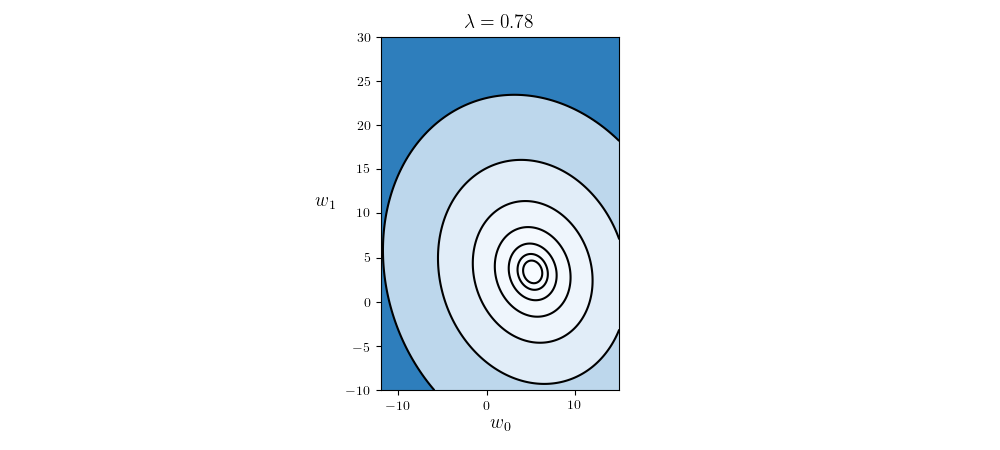
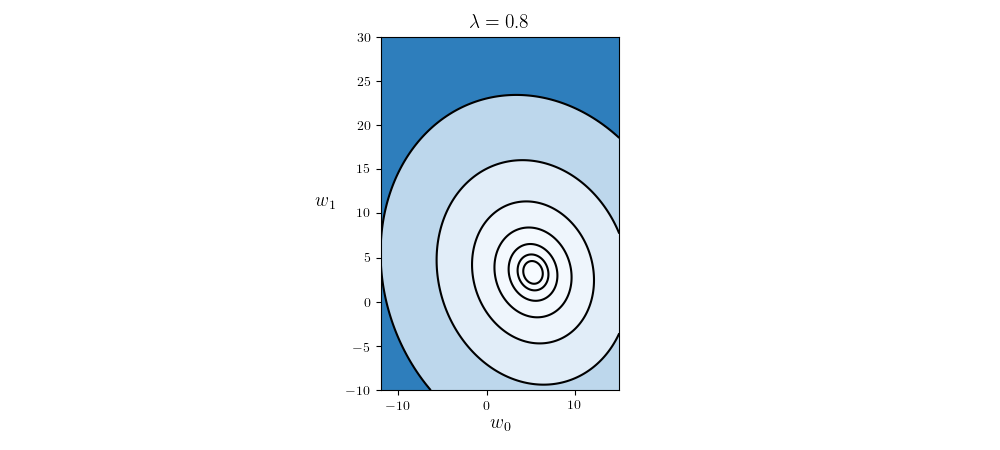
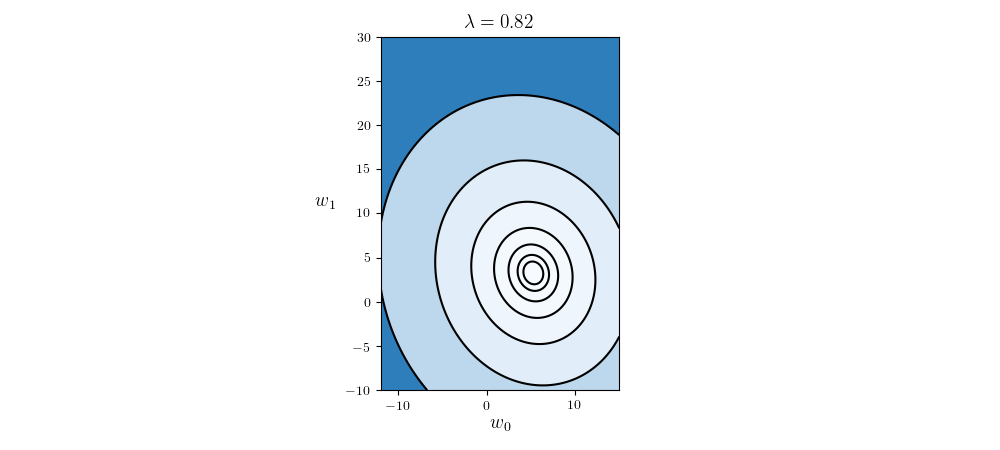
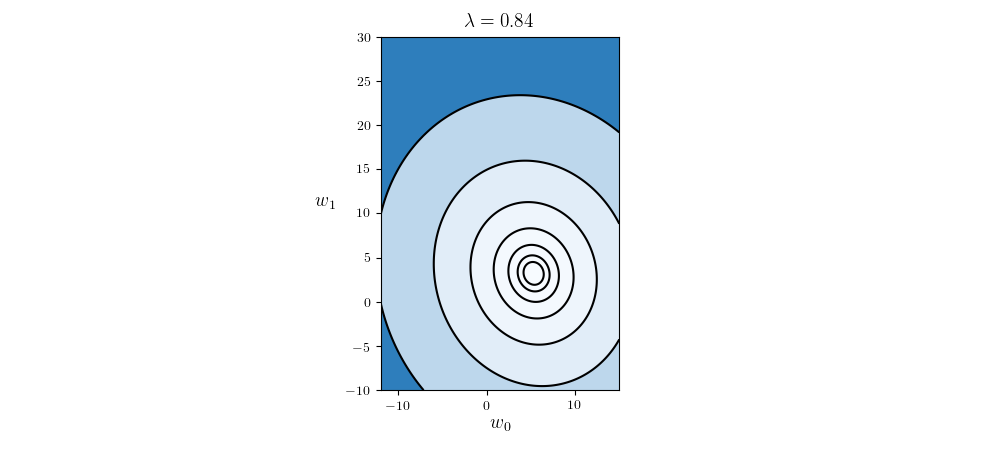
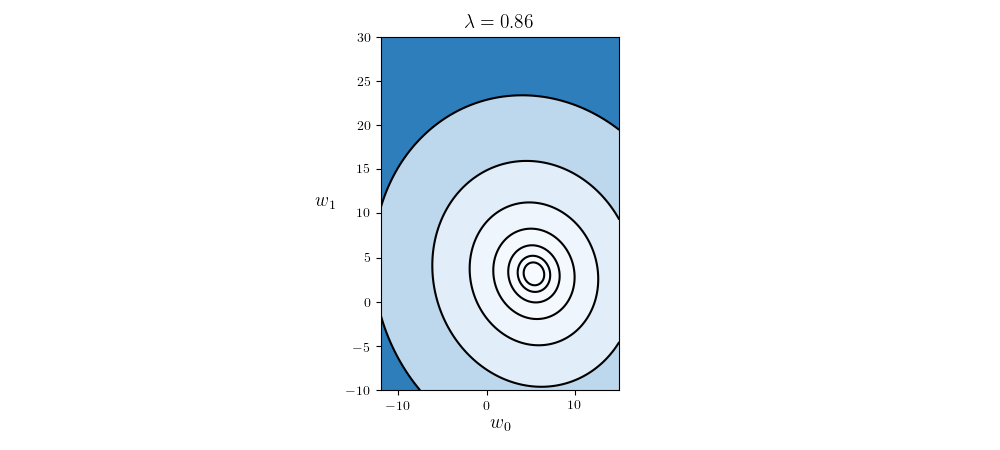
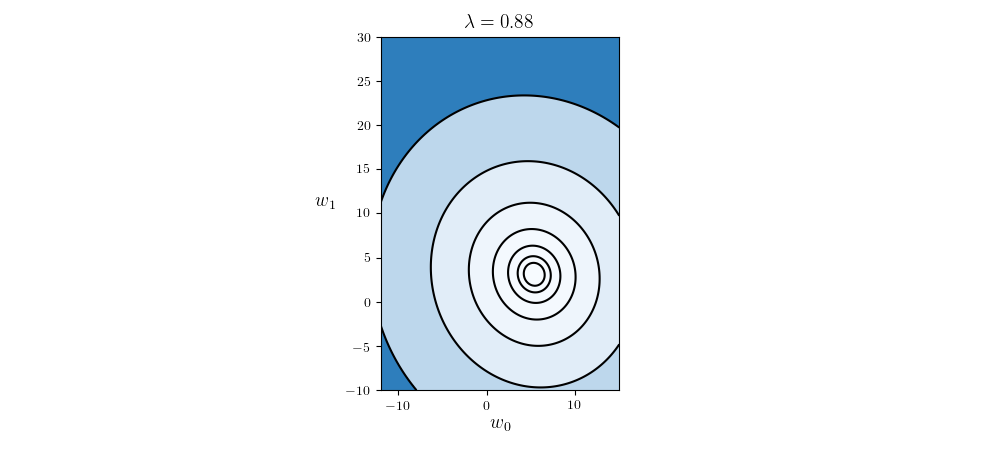
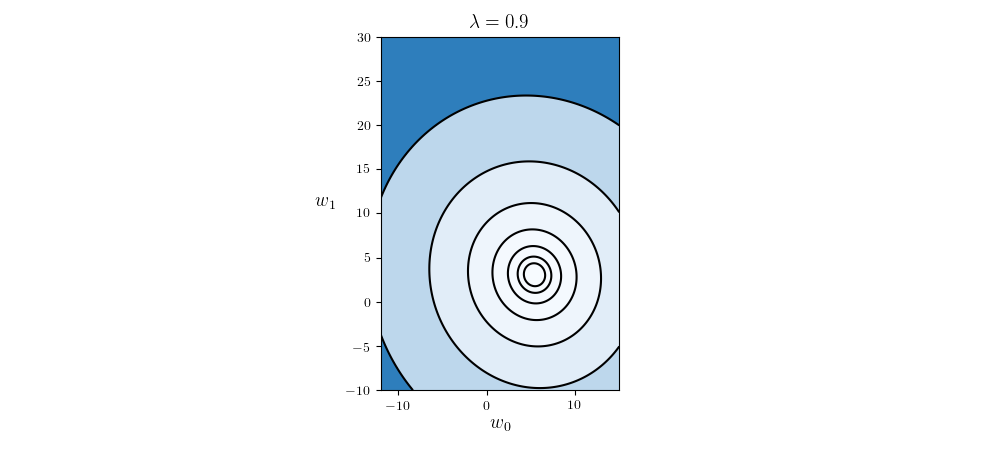
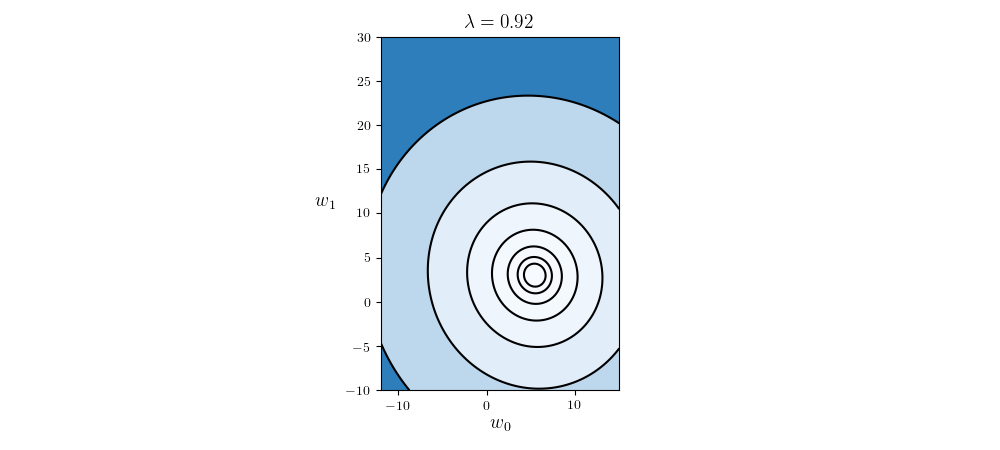
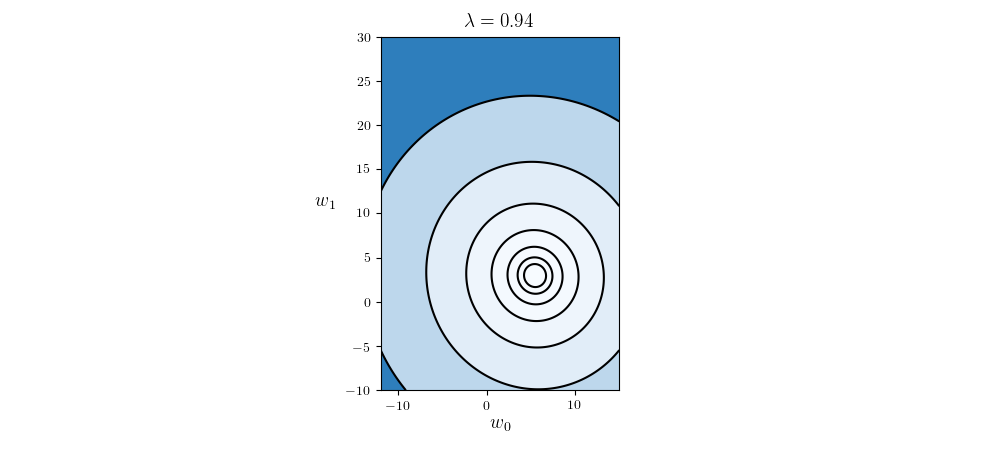
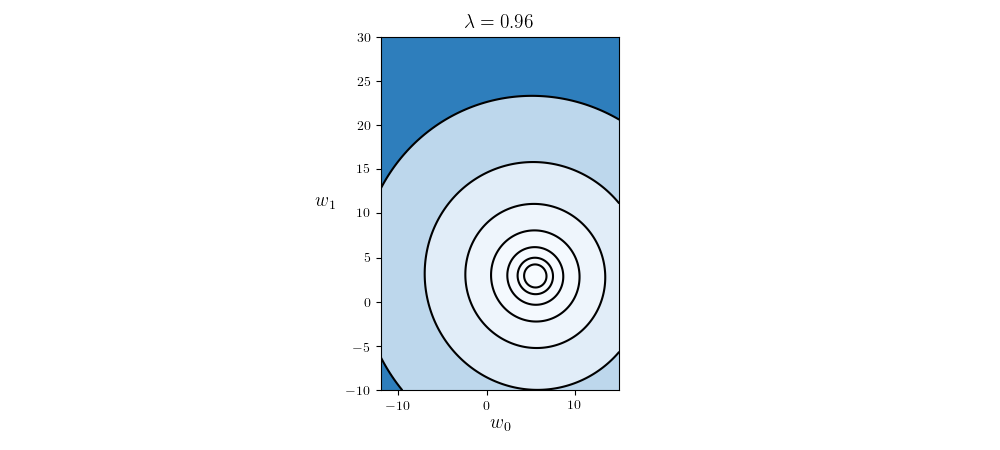
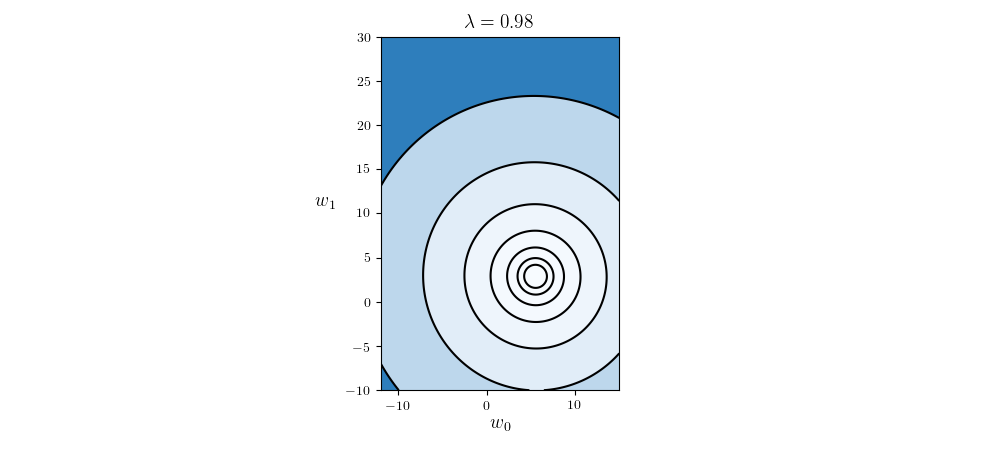
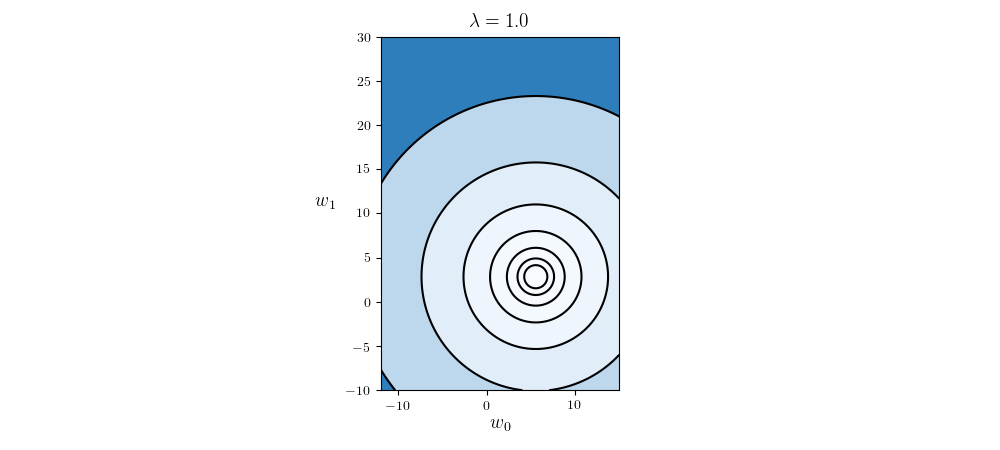

In [27]:
# animation showing cost function transformation from standard to normalized input
scaling_tool = feature_scaling_tools.Visualizer(x,x_normalized,y,'least_squares')
scaling_tool.animate_transition(num_frames=50,xmin = -12,xmax = 15,ymin = -10,ymax = 30,num_contours = 7)

- now lets make the same sort of gradient descent run on the normalied input cost

In [12]:
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares_2; w = np.array([0.0,0.0])[:,np.newaxis]; max_its = 20; alpha_choice = 10**(-1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

<IPython.core.display.Javascript object>


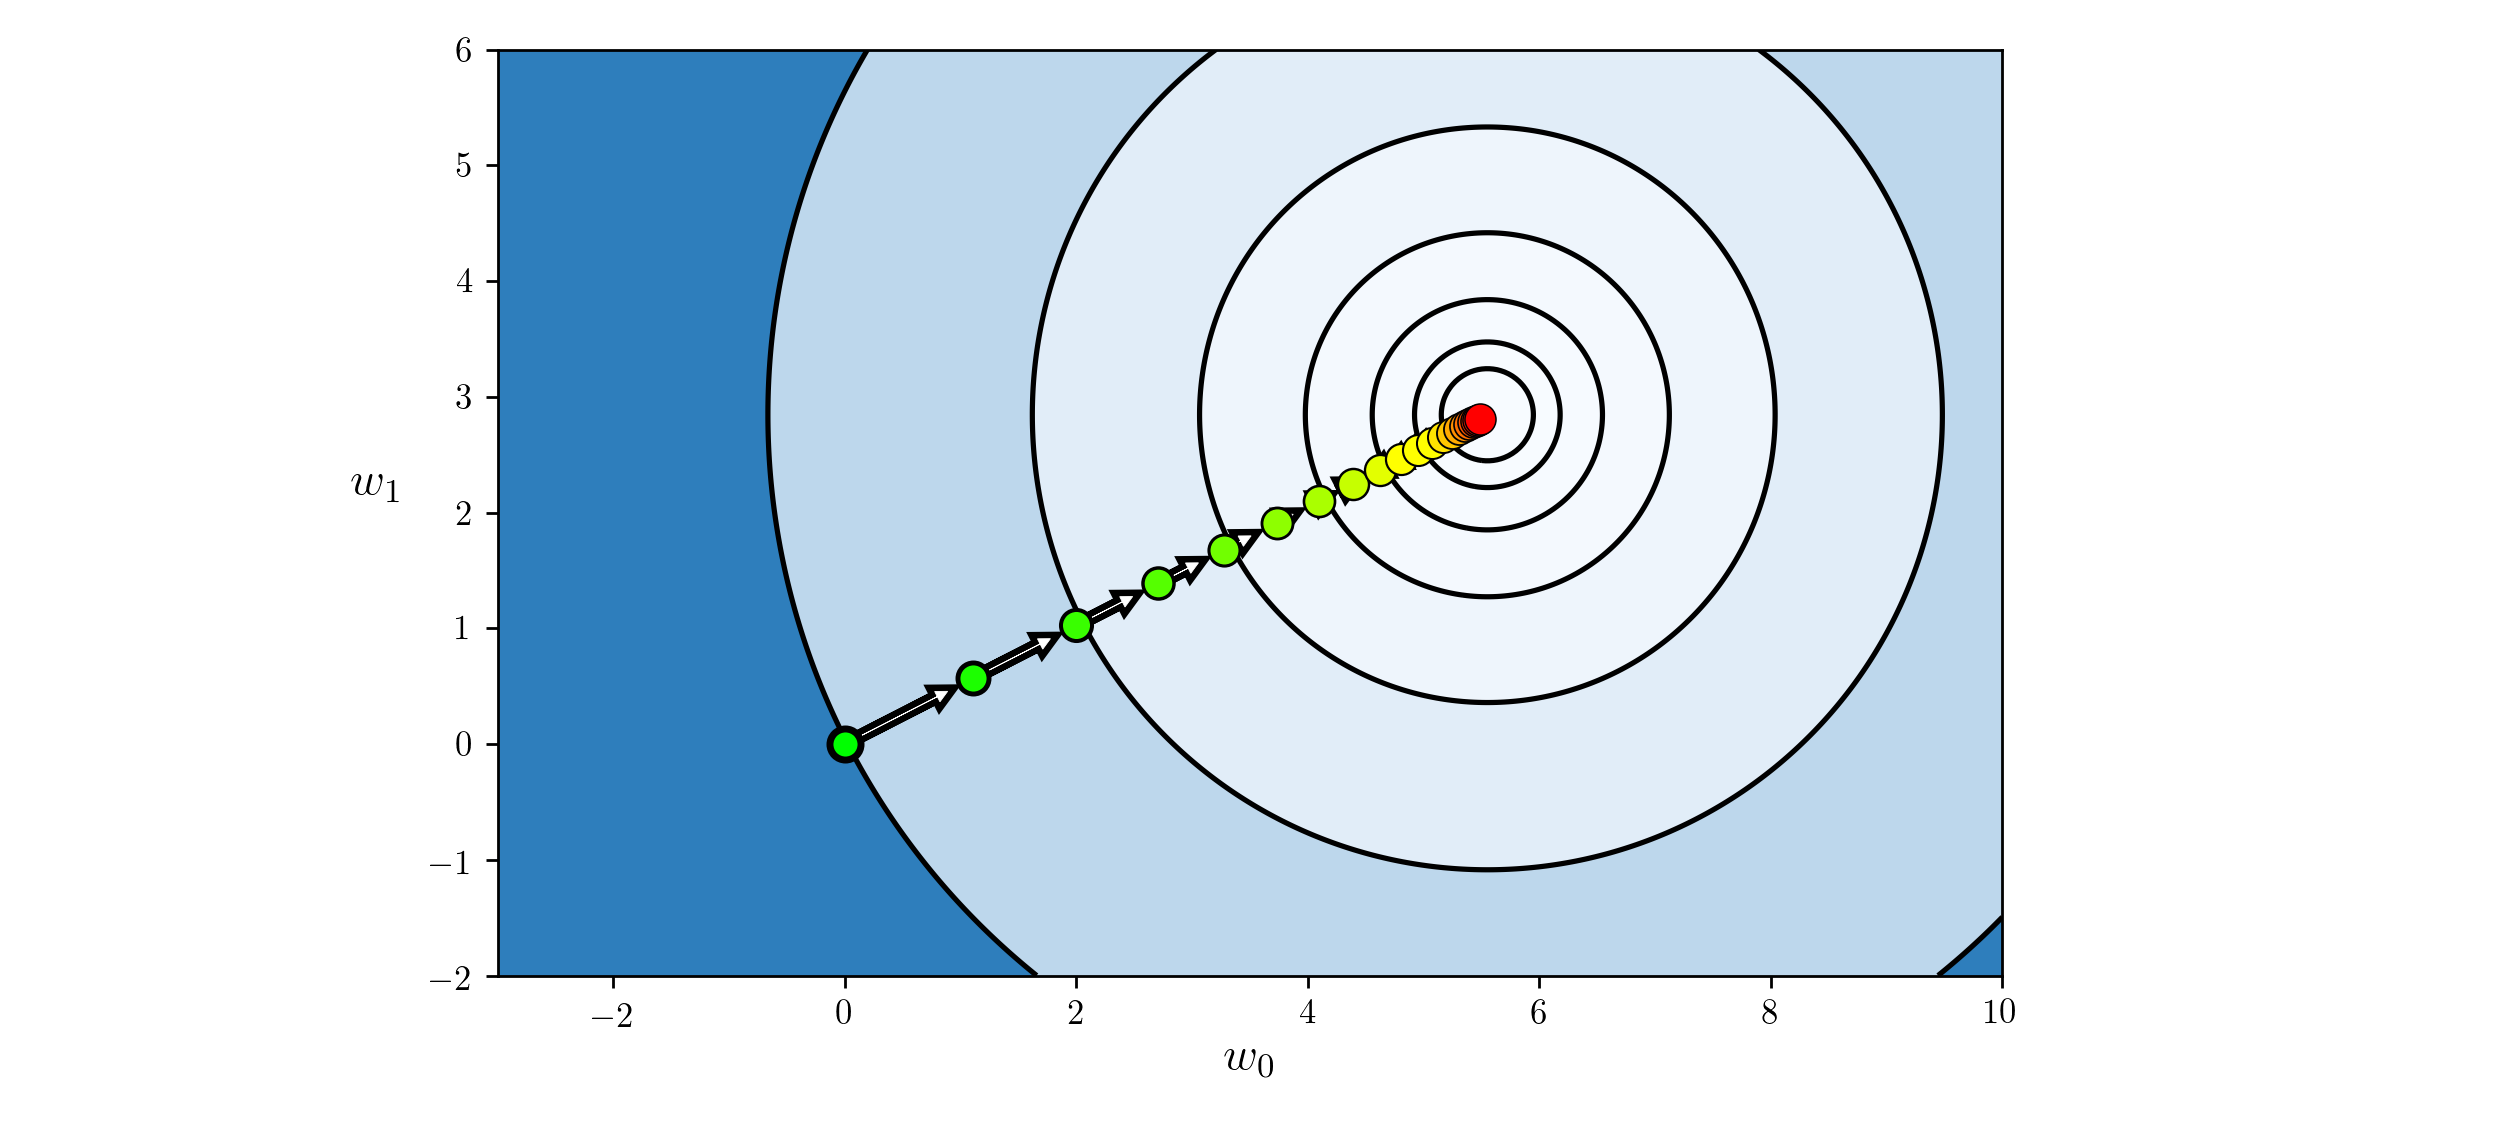

In [13]:
# show run on contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -3,xmax = 10,ymin = -2,ymax = 6,num_contours = 7,show_original = False)

- much much better!

- how about the resulting fit?

<IPython.core.display.Javascript object>


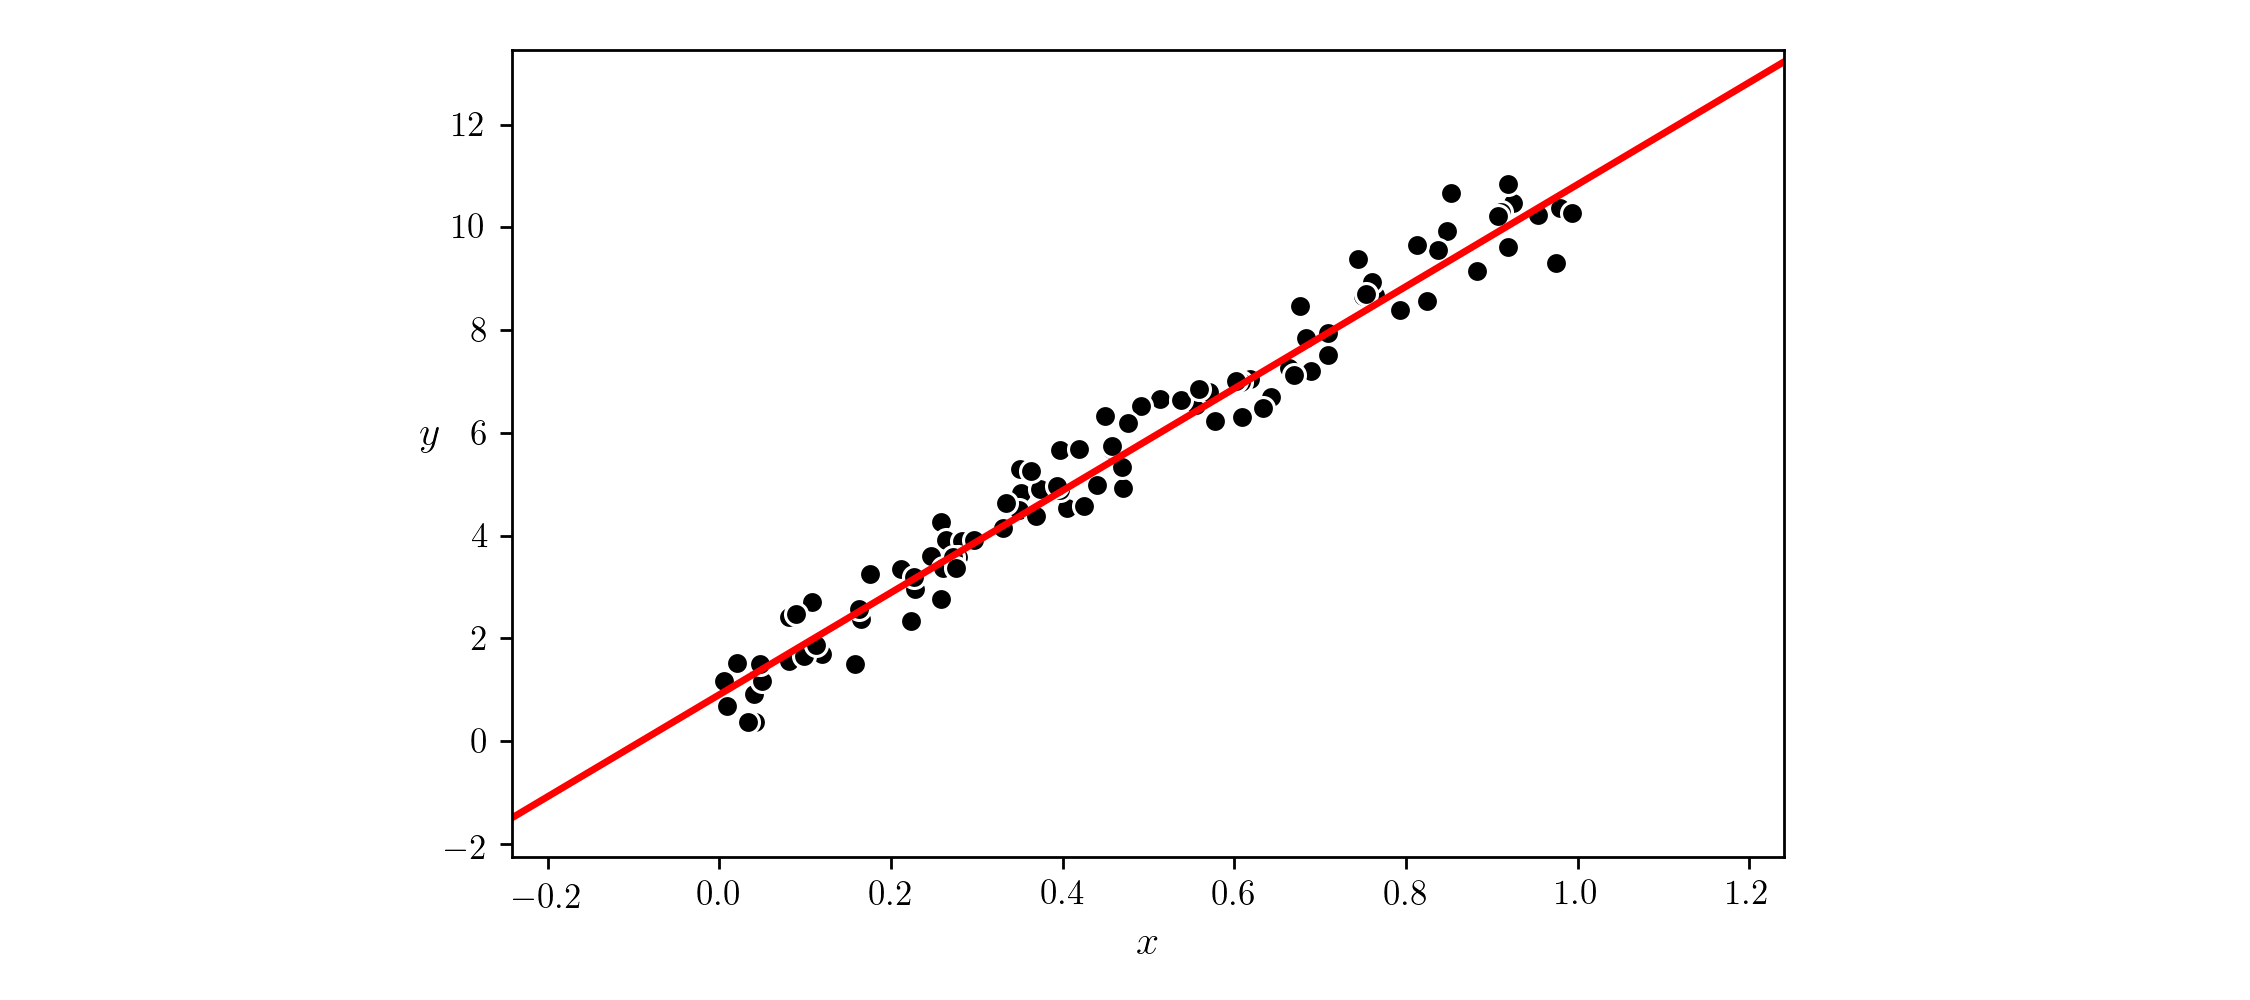

In [14]:
# the original data and best fit line learned from our gradient descent run
ind = np.argmin(cost_history)
least_weights = weight_history[ind]
demo.plot_fit(plotting_weights = [least_weights],colors = ['r'],transformer = normalizer)

- not here - to produce the fit we plug in new test points 

- new test points need to be treated precisely as the training data - subtract the same mean / divide by the same std

\begin{equation}
\text{normalized_predictor}\left(x\right) = w_0^{\star} + w_1^{\star}\left(\frac{x - \mu}{\sigma}\right).
\end{equation}

#### <span style="color:#a50e3e;"> Example 1. </span>  Normalizing the input of a student debt dataset

- does standard normalization work for real data?

- absolutely - e.g., United States student debt dataset

<IPython.core.display.Javascript object>


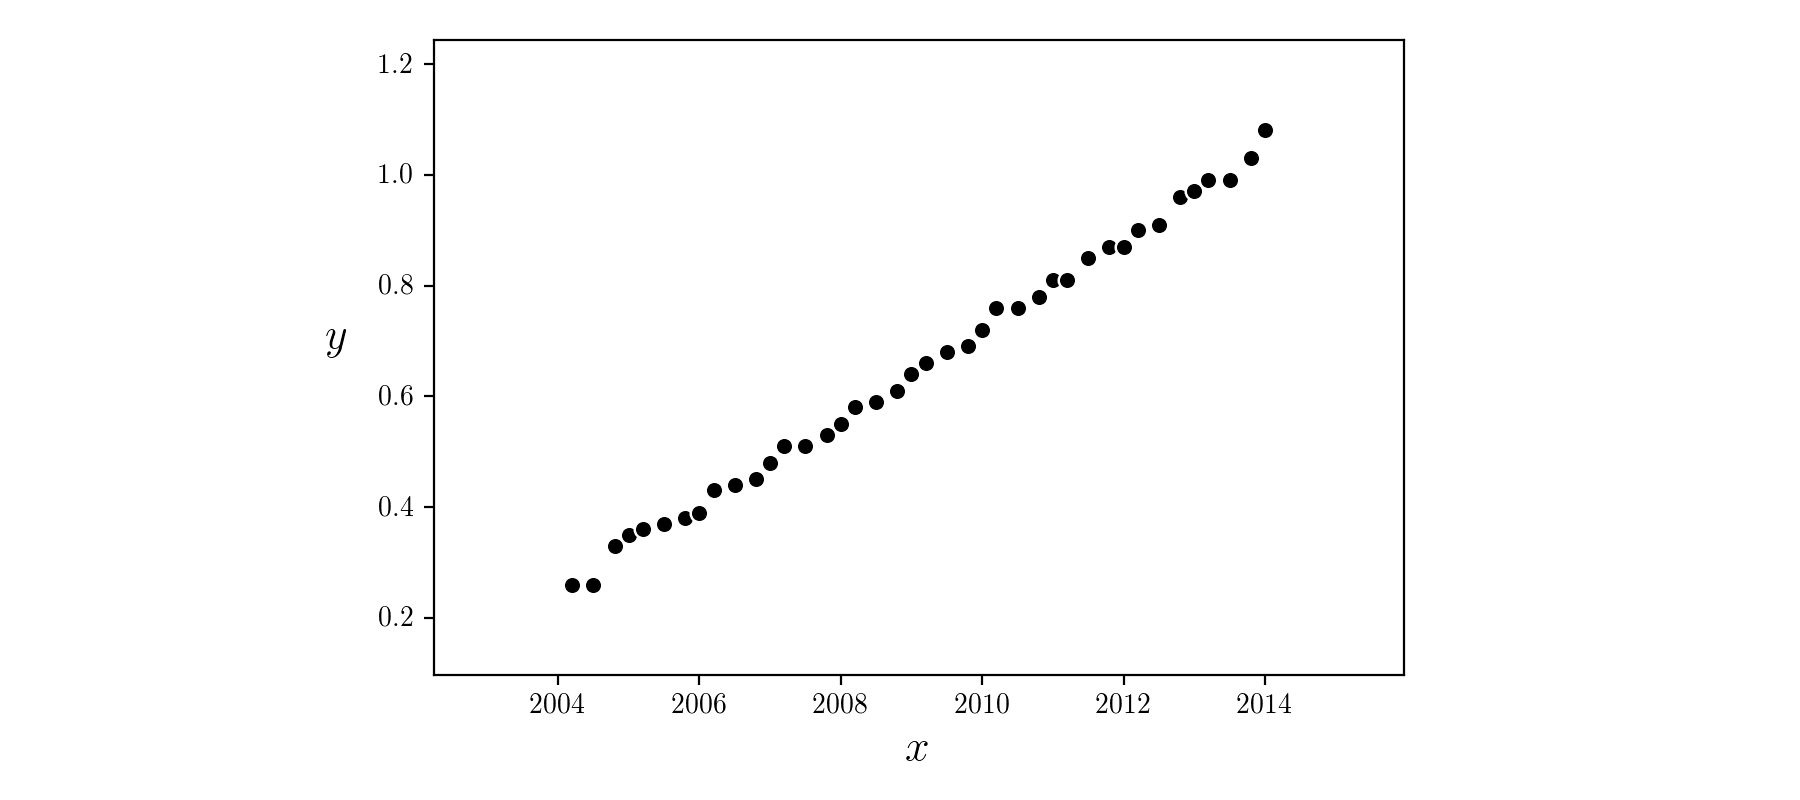

In [3]:
# load data
csvname = datapath + 'student_debt.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1].T
y = data[:,-1:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

- Least Squares cost before performing standard normalization to input, with run of 25 gradient descent steps

<IPython.core.display.Javascript object>


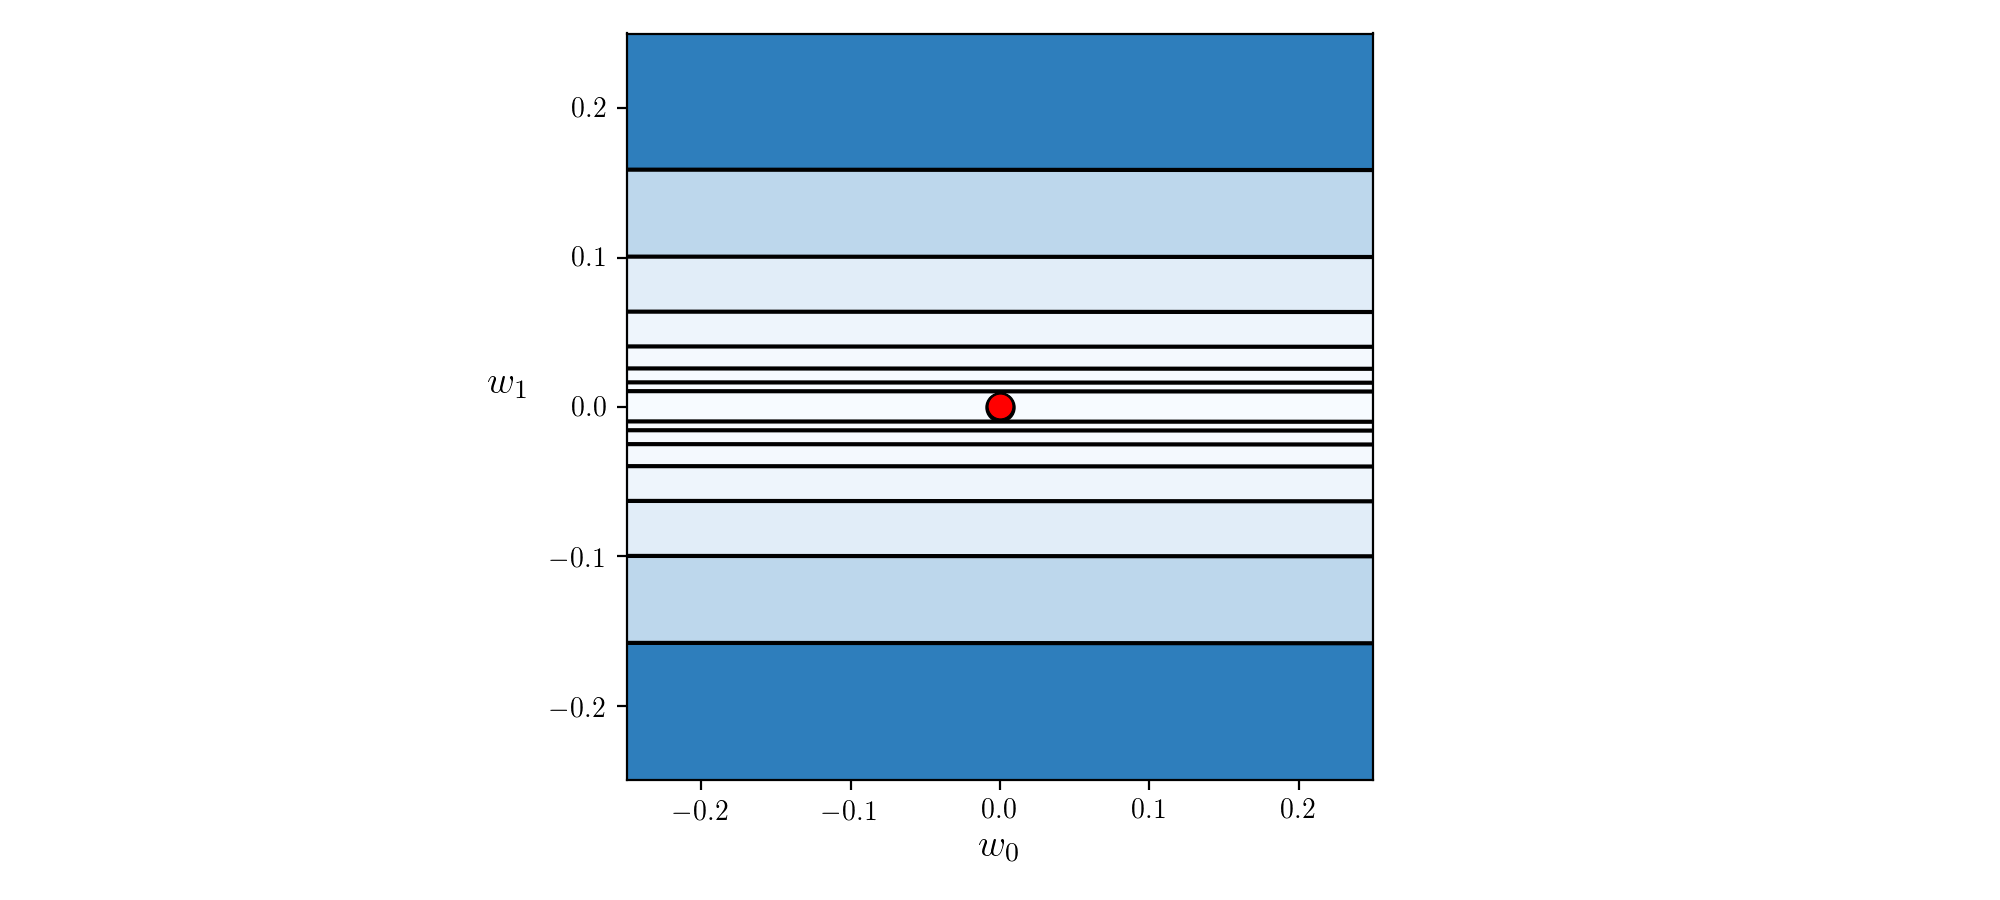

In [4]:
# an implementation of the least squares cost function for linear regression, precisely
# what was shown in Section 8.1 but here pulled in from a backend file
least_squares = cost_lib.choose_cost(x,y,'least_squares')

# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; w = np.array([0.0,0.0])[:,np.newaxis]; max_its = 25; alpha_choice = 10**(-7);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# show run on contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -0.25,xmax = 0.25,ymin = -0.25,ymax = 0.25,num_contours = 7,show_original = False)

- hugely elliptical! basically impossible to minimize via gradient descent   

- because the original input is enormous!   so even slight variations from the very best slope/vertical intercept produce huge eroors

- corresponding fit will be terrible

<IPython.core.display.Javascript object>


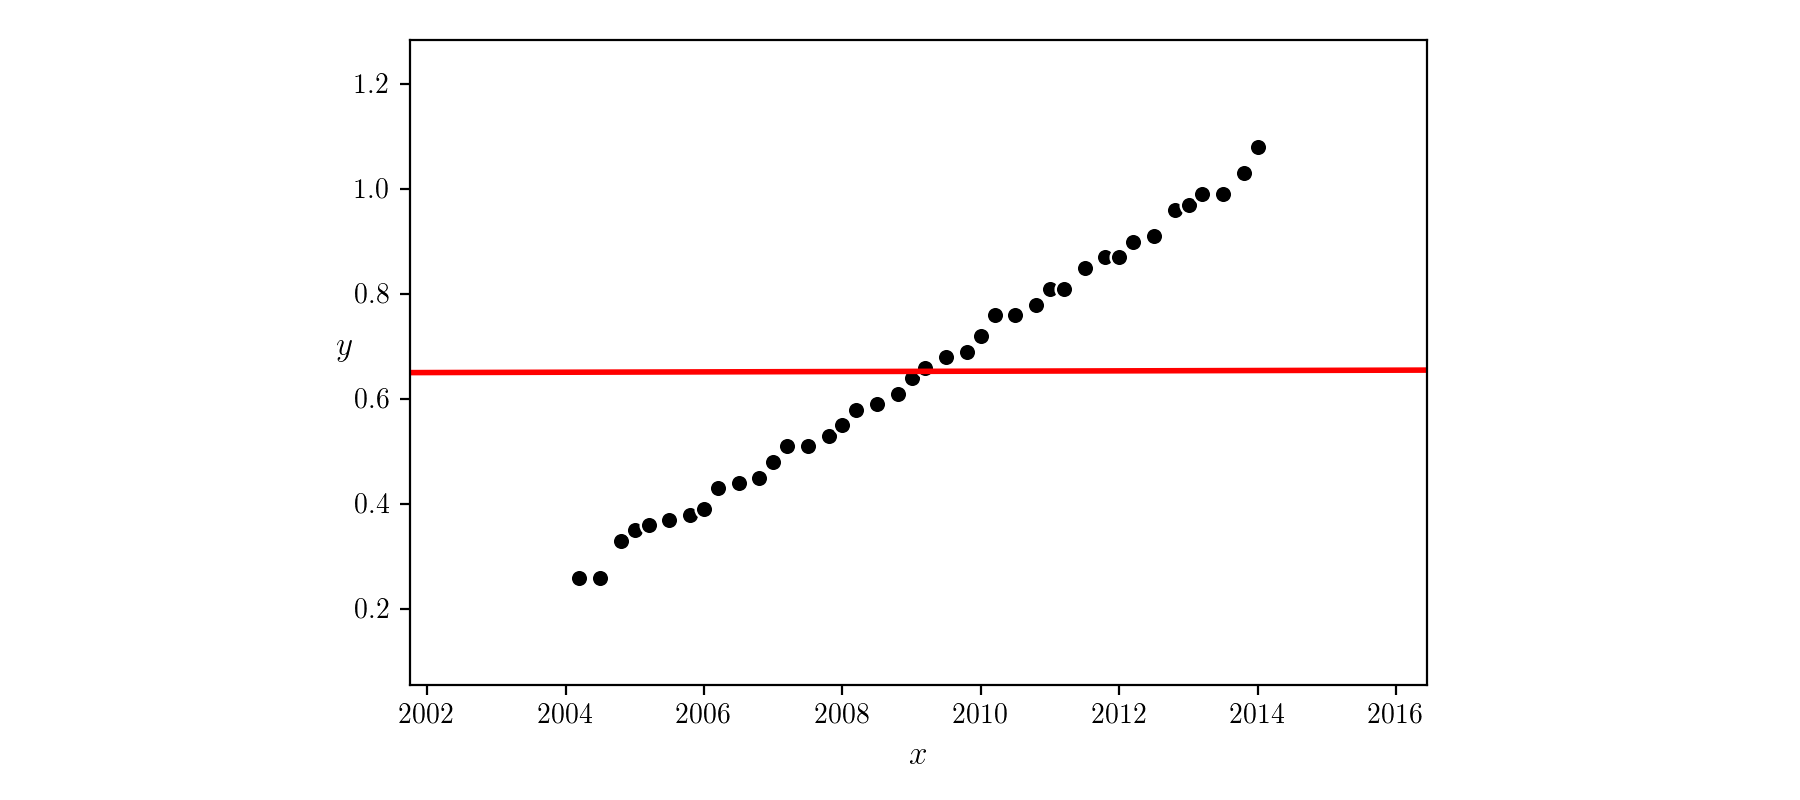

In [5]:
# the original data and best fit line learned from our gradient descent run
ind = np.argmin(cost_history)
least_weights = weight_history[ind]
demo.plot_fit(plotting_weights = [least_weights],colors = ['r'])

- after standard normalization, with only $25$ gradient descent steps - with much larger steplength!

<IPython.core.display.Javascript object>


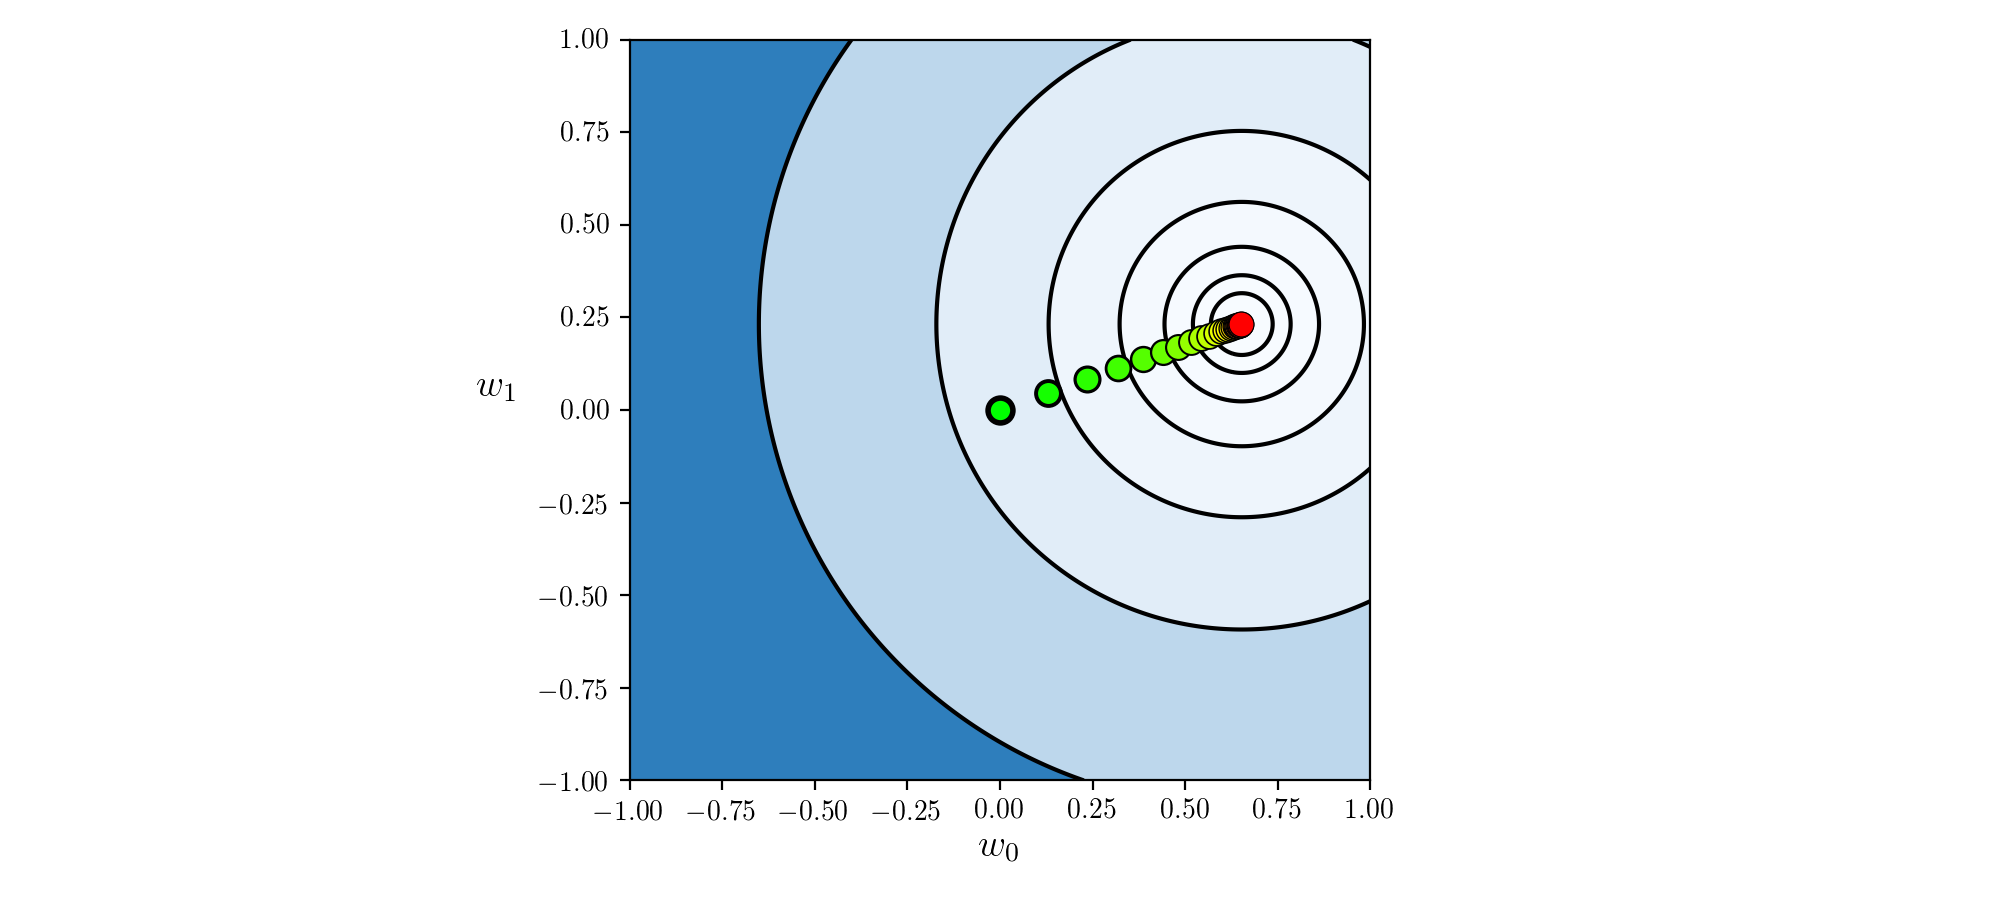

In [9]:
# return normalization and inverse normalization functions based on input x
normalizer = standard_normalizer(x)

# normalize input by subtracting off mean and dividing by standard deviation
x_normalized = normalizer(x)

# an implementation of the least squares cost function for linear regression, precisely
# what was shown in Section 8.1 but here pulled in from a backend file
least_squares_2 = cost_lib.choose_cost(x_normalized,y,'least_squares')

# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares_2; w = np.array([0.0,0.0])[:,np.newaxis]; max_its = 25; alpha_choice = 10**(-1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# show run on contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -1,xmax = 1,ymin = -1,ymax = 1,num_contours = 7,show_original = False,arrows = False)

- way better fit possible

<IPython.core.display.Javascript object>


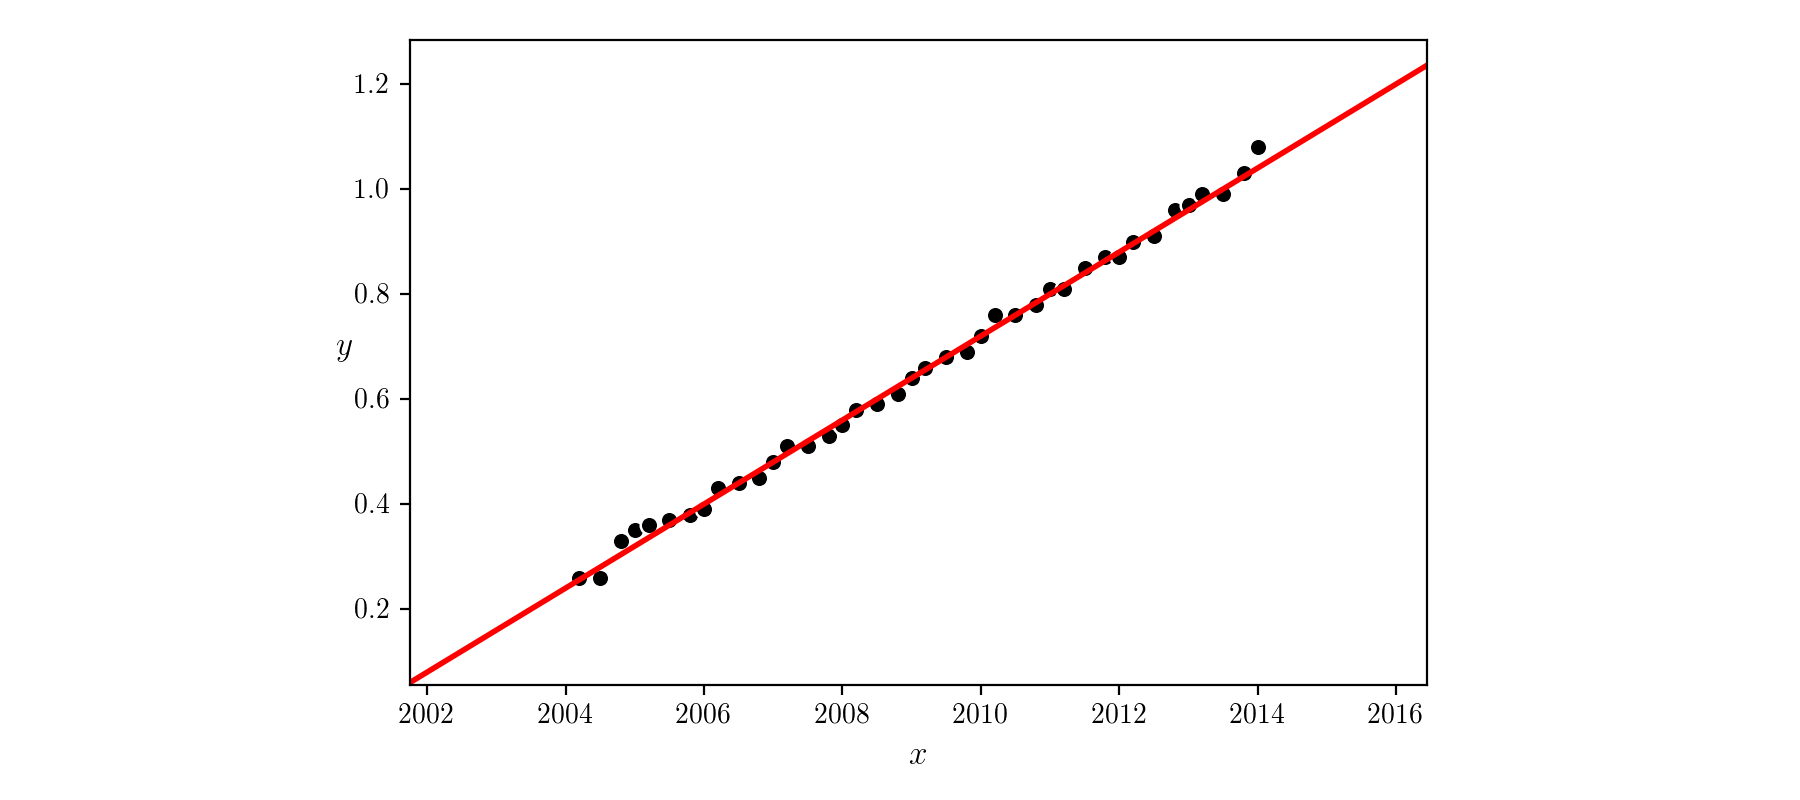

In [10]:
# the original data and best fit line learned from our gradient descent run
ind = np.argmin(cost_history)
least_weights = weight_history[ind]
demo.plot_fit(plotting_weights = [least_weights],colors = ['r'],transformer = normalizer)

## 8.4.2 Feature scaling for multi-input datasets

- the same standard normalization scheme aids in tuning models for multi-innput regression data as well

- simply do the same thing - mean center and scale by standard deviation - for each input

- normalize the $n^{th}$ input dimension of an $N$-input dimensional dataset $\left\{\mathbf{x}_p,y_p\right\}_{p=1}^N$ as 

\begin{equation}
x_{p,n} \longleftarrow \frac{x_{p,n} - \mu_n}{\sigma_n}
\end{equation}

where

\begin{array}
\
\mu_n = \frac{1}{P}\sum_{p=1}^{P}x_{p,n} \\
\sigma_n = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_{p,n} - \mu_n \right)^2}
\end{array}

- see Section notes for examples!

## 8.4.3  Summary and discussion

<figure>
  <img src= '../../mlrefined_images/superlearn_images/standard_normalization_data_and_contours.png' width="100%" height="auto" alt=""/>
</figure>

- making the contours of a cost function more 'circular' make it easier to minimize - why?

- e.g., for gradient descent due to the nature of the gradient descent direction!

- this direction points orthogonal to contours - in long narrow valleys this points away from cost minimum, on circular cost it points more towards minimum

<figure>
  <img src= '../../mlrefined_images/superlearn_images/better_contours.png' width="100%" height="auto" alt=""/>
  <figcaption>   